# import

In [3]:
import numpy as np
import dimod
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import matplotlib as mpl
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os

In [4]:

from dwave.system import DWaveSampler

# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


In [5]:
#set a simulated annealer sampler
simsampler=dimod.SimulatedAnnealingSampler()

# functions

In [6]:
#define a function to turn lists of tuples (edges) into arrays
def TuptoArray(tuplist):
    list0=[]
    list1=[]
    for tup in tuplist:
        list0.append(tup[0])
        list1.append(tup[1])
    edgearray=np.array([list0,list1])
    return edgearray

In [7]:
#define functions to tile any hex or tri array to the right or down
def tile_right(inp_arr):
    add_arr = np.empty(shape=inp_arr.shape)
    
    for i in range(len(inp_arr)):
        for j in range(len(inp_arr[i])):
            qub=inp_arr[i][j]
            if qub in horizontals:
                add_arr[i][j]=64
            if qub in verticals:
                add_arr[i][j]=1   
    
    out_arr = inp_arr + add_arr
    return out_arr

def tile_left(inp_arr):
    sub_arr = np.empty(shape=inp_arr.shape)
    
    for i in range(len(inp_arr)):
        for j in range(len(inp_arr[i])):
            qub=inp_arr[i][j]
            if qub in horizontals:
                sub_arr[i][j]=64
            if qub in verticals:
                sub_arr[i][j]=1   
    
    out_arr = inp_arr - sub_arr
    return out_arr

def tile_down(inp_arr):
    add_arr = np.empty(shape=inp_arr.shape)
    
    for i in range(len(inp_arr)):
        for j in range(len(inp_arr[i])):
            qub=inp_arr[i][j]
            if qub in horizontals:
                add_arr[i][j]=1
            if qub in verticals:
                add_arr[i][j]=64   
    
    out_arr = inp_arr + add_arr
    return out_arr

In [8]:
def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [9]:
#define a function to tile the base hexs and tris to the desired lattice size
def NxN_tile(N,fold):
    
    #initialize the registries with the base arrays
    hex1reg=[]
    hex1reg.append(hex1base)
    hex2reg=[]
    hex2reg.append(hex2base)
    tri1reg=[]
    tri1reg.append(tri1base)
    tri2reg=[]
    tri2reg.append(tri2base)
    tri3reg=[]
    tri3reg.append(tri3base)
    tri4reg=[]
    tri4reg.append(tri4base)
    
    if fold==True:
        hex3reg=[]
        hex3reg.append(hex3base)
        hex4reg=[]
        hex4reg.append(hex4base)
        hex5reg=[]
        hex5reg.append(hex5base)
        tri5reg=[]
        tri5reg.append(tri5base)
        tri6reg=[]
        tri6reg.append(tri6base)
        tri7reg=[]
        tri7reg.append(tri7base)
        tri8reg=[]
        tri8reg.append(tri8base)
        tri9reg=[]
        tri9reg.append(tri9base)
    
    #tile layer 1 to the right, tile layer 2 to the left
    for i in range(N-1):
        hex1reg.append(tile_right(hex1reg[i]))
        hex2reg.append(tile_right(hex2reg[i]))
        tri1reg.append(tile_right(tri1reg[i]))
        tri2reg.append(tile_right(tri2reg[i]))
        tri3reg.append(tile_right(tri3reg[i]))
        tri4reg.append(tile_right(tri4reg[i]))
        if fold==True:
            hex4reg.append(tile_left(hex4reg[i]))
            tri6reg.append(tile_left(tri6reg[i]))
            tri7reg.append(tile_left(tri7reg[i]))
            tri8reg.append(tile_left(tri8reg[i]))
    for i in range(N-2):    
        if fold==True:
            hex5reg.append(tile_left(hex5reg[i]))
            tri9reg.append(tile_left(tri9reg[i]))
        
    #now every registry has the first row of hexs or tris
    hex1row=hex1reg
    hex2row=hex2reg
    tri1row=tri1reg
    tri2row=tri2reg
    tri3row=tri3reg
    tri4row=tri4reg
    if fold==True:
        hex3row=hex3reg
        hex4row=hex4reg
        hex5row=hex5reg
        tri5row=tri5reg
        tri6row=tri6reg
        tri7row=tri7reg
        tri8row=tri8reg
        tri9row=tri9reg

    for i in range(N-1):
        newrowhex1=[]
        for j in range(len(hex1row)):
            hex1reg.append(tile_down(hex1row[j]))
            newrowhex1.append(tile_down(hex1row[j]))
        hex1row=newrowhex1
        
        if fold==True:
            newrowhex3=[]
            for j in range(len(hex3row)):
                hex3reg.append(tile_down(hex3row[j]))
                newrowhex3.append(tile_down(hex3row[j]))
            hex3row=newrowhex3
            newrowhex5=[]
            for j in range(len(hex5row)):
                hex5reg.append(tile_down(hex5row[j]))
                newrowhex5.append(tile_down(hex5row[j]))
            hex5row=newrowhex5
            
        newrowtri1=[]
        for j in range(len(tri1row)):
            tri1reg.append(tile_down(tri1row[j]))
            newrowtri1.append(tile_down(tri1row[j]))
        tri1row=newrowtri1
        newrowtri2=[]
        for j in range(len(tri2row)):
            tri2reg.append(tile_down(tri2row[j]))
            newrowtri2.append(tile_down(tri2row[j]))
        tri2row=newrowtri2
        
        if fold==True:
            newrowtri7=[]
            for j in range(len(tri7row)):
                tri7reg.append(tile_down(tri7row[j]))
                newrowtri7.append(tile_down(tri7row[j]))
            tri7row=newrowtri7
            newrowtri8=[]
            for j in range(len(tri8row)):
                tri8reg.append(tile_down(tri8row[j]))
                newrowtri8.append(tile_down(tri8row[j]))
            tri8row=newrowtri8
        
    for i in range(N-2):
        newrowhex2=[]
        for j in range(len(hex2row)):
            hex2reg.append(tile_down(hex2row[j]))
            newrowhex2.append(tile_down(hex2row[j]))
        hex2row=newrowhex2
        
        if fold==True:
            newrowhex4=[]
            for j in range(len(hex4row)):
                hex4reg.append(tile_down(hex4row[j]))
                newrowhex4.append(tile_down(hex4row[j]))
            hex4row=newrowhex4
            
        newrowtri3=[]
        for j in range(len(tri3row)):
            tri3reg.append(tile_down(tri3row[j]))
            newrowtri3.append(tile_down(tri3row[j]))
        tri3row=newrowtri3
        newrowtri4=[]
        for j in range(len(tri4row)):
            tri4reg.append(tile_down(tri4row[j]))
            newrowtri4.append(tile_down(tri4row[j]))
        tri4row=newrowtri4
        
        if fold==True:
            newrowtri5=[]
            for j in range(len(tri5row)):
                tri5reg.append(tile_down(tri5row[j]))
                newrowtri5.append(tile_down(tri5row[j]))
            tri5row=newrowtri5
            newrowtri6=[]
            for j in range(len(tri6row)):
                tri6reg.append(tile_down(tri6row[j]))
                newrowtri6.append(tile_down(tri6row[j]))
            tri6row=newrowtri6
            newrowtri9=[]
            for j in range(len(tri9row)):
                tri9reg.append(tile_down(tri9row[j]))
                newrowtri9.append(tile_down(tri9row[j]))
            tri9row=newrowtri9
            
    if fold==False:
        hex3reg=[]
        hex4reg=[]
        hex5reg=[]
        tri5reg=[]
        tri6reg=[]
        tri7reg=[]
        tri8reg=[]
        tri9reg=[]
        
    return hex1reg,hex2reg,hex3reg,hex4reg,hex5reg,tri1reg,tri2reg,tri3reg,tri4reg,tri5reg,tri6reg,tri7reg,tri8reg,tri9reg

In [10]:
def RegsToTups(all_regs):
    alledges=[]
    allnodes=[]
    for arr in all_regs:
        list0=arr[0]
        list1=arr[1]
        for i in range(len(list0)):
            qubit0=int(list0[i])
            qubit1=int(list1[i])
            alledges.append((qubit0,qubit1))
            allnodes.append(qubit0)
            allnodes.append(qubit1)
    allnodes=set(allnodes)
    return alledges,allnodes

In [11]:
def magnetization(response):
    mags=[]
    for i in range(len(response.lowest().record)):
        run_pms=response.record[i][0]
        mags.append(np.mean(run_pms))

    avgmag=np.mean(mags)

    return mags,avgmag

In [12]:
# function to fill in missing couplers by using another coupler
def find_intersection(missedge,allnodes,missingcoups,missingqs):

    #these are the two qubits constituting the missing coupler
    q0m = missedge[0]
    q1m = missedge[1]

    # a list of all of the couplers associated with q0m and q1m
    candidates = []
    # from candidates, all of the qubits connected to q0m and those connected to q1m
    q0mcoups = []
    q1mcoups = []

    if (q0m not in missingqs and q1m not in missingqs):
        for availedge in sampler.edgelist:
            q0a = availedge[0]
            q1a = availedge[1]

            if (q0a == q0m or q1a == q1m or q0a == q1m or q1a == q0m):
                candidates.append(availedge)

        for cand in candidates:
            if (cand[0] == q0m or cand[1] == q0m):
                q0mcoups.append(cand[0])
                q0mcoups.append(cand[1])
            if (cand[0] == q1m or cand[1] == q1m):
                q1mcoups.append(cand[0])
                q1mcoups.append(cand[1])

    else:
        if q0m in missingqs:
            print(q0m, "missing")
            missingqubit=q0m
        if q1m in missingqs:
            missingqubit=q1m
            print(q1m, "missing")
        
        
        

    for qubit in q0mcoups:
        if qubit == q0m:
            q0mcoups.remove(qubit)
    for qubit in q1mcoups:
        if qubit == q1m:
            q1mcoups.remove(qubit)
            
    q0mcoups = set(q0mcoups)
    q1mcoups = set(q1mcoups)

    #find the intersection
    intersection = q0mcoups.intersection(q1mcoups)
    intersection = list(intersection)
        
    #for every intersection qubit, check if it is already in use in the embedding
    #if no good intersection exists, the missing coupler is unresolved
    if len(intersection) != 0:
        goodinter=[]
        for inter in intersection:
            if inter not in allnodes:
                goodinter.append(inter)
        if len(goodinter)==0:
            unresolved=True
        else:
            unresolved=False
    else:
        unresolved=True
        

    return intersection,goodinter,unresolved


In [13]:
def resolve_unresolved(unres, allnodes, missingqs):

    #these are the two qubits constituting the missing coupler
    q0m = unres[0]
    q1m = unres[1]

    # a list of all of the couplers associated with q0m and q1m
    candidates = []
    # from candidates, all of the qubits connected to q0m and those connected to q1m
    q0mcoups = []
    q1mcoups = []

    if (q0m not in missingqs and q1m not in missingqs):
        for availedge in sampler.edgelist:
            q0a = availedge[0]
            q1a = availedge[1]

            if (q0a == q0m or q1a == q1m or q0a == q1m or q1a == q0m):
                candidates.append(availedge)

        for cand in candidates:
            if (cand[0] == q0m or cand[1] == q0m):
                q0mcoups.append(cand[0])
                q0mcoups.append(cand[1])
            if (cand[0] == q1m or cand[1] == q1m):
                q1mcoups.append(cand[0])
                q1mcoups.append(cand[1])

    else:
        print("one or more of the qubits in this coupler are missing")
        

    for qubit in q0mcoups:
        if qubit == q0m:
            q0mcoups.remove(qubit)
    for qubit in q1mcoups:
        if qubit == q1m:
            q1mcoups.remove(qubit)

    q0mcontigs = list(set(q0mcoups))
    q1mcontigs = list(set(q1mcoups))

#     print(q0mcontigs)
#     print(q1mcontigs)

    candidates = []
    for q0 in q0mcontigs:
        for q1 in q1mcontigs:
            if (((q0, q1) in sampler.edgelist or Reverse(
                (q0, q1)) in sampler.edgelist)
                    and (q0 not in allnodes and q1 not in allnodes)):
                candidates.append((q0, q1))

    for cand in candidates:

        two_2chains = [(q0m, cand[0]), (q1m, cand[1])]
        verified_2chains = []
        for chain in two_2chains:
            if chain in sampler.edgelist:
                verified_2chains.append(chain)
            else:
                if Reverse(chain) in sampler.edgelist:
                    verified_2chains.append(Reverse(chain))

            if (len(verified_2chains) == 2
                    and (cand in sampler.edgelist
                         or Reverse(cand) in sampler.edgelist)):
                finalafm = cand
                final_2chains = verified_2chains
                break

    return finalafm, final_2chains

In [14]:
def check_nodes(nodes):
    missingqubits = []
    for node in nodes:
        if node not in sampler.nodelist:
            missingqubits.append(node)
    return missingqubits

In [15]:
def check_edges(edges):
    missingedges=[]
    for edge in edges:
        if edge not in sampler.edgelist and Reverse(edge) not in sampler.edgelist:
            missingedges.append(edge)
    return missingedges

In [16]:
def remove_tup_repeats(edges):
    edges_norepeats=[]
    for edge in edges:
        if (edge not in edges_norepeats and Reverse(edge) not in edges_norepeats):
            edges_norepeats.append(edge)
    return edges_norepeats

In [17]:
def DocName(jafm,k2,h1,h2,s):
    
    str1="J="+str(jafm)
    str2="h1,h2,k2,s="+str(h1)+","+str(h2)+","+str(k2)+","+str(s)
    now = datetime.now()
    str3 = now.strftime("%m-%d-%y__%H-%M-%S")
    
    Documentname=str1+'__'+str2+'__'+str3
    
    return Documentname

In [18]:
def set_jkhs(jafm, k2, h1, s):

    h2 = h1 / 2

    #make an array of these values
    paramsarray = np.array([['jafm', 'k2', 'h1', 'h2', 's'],
                            [jafm, k2, h1, h2, s]])

    return paramsarray

In [19]:
def set_params_array(paramsdict):
    paramsarray = np.array([list(paramsdict.keys()), list(paramsdict.values())])
    return paramsarray

In [20]:
def checks(alledges,allnodes):

    #remove repeats
#     print(len(alledges),"edges to start with")
    edges_norepeats = remove_tup_repeats(alledges)
#     print(len(edges_norepeats),"edges without repeats")

    #check for missing qubits
    missingqs=check_nodes(allnodes)
#     print("missing qubits:",missingqs)

    #check for missing couplers
    missingcoups=check_edges(edges_norepeats)
#     print("missing couplers:",missingcoups)

    ##### There are 2 types of missing couplers.
    ####### The easier one is a coupler that is itself missing or faulty.
    ######### We fix this by making one or both of the qubits into chain(s) and then connecting them.
    ####### The annoying case is when there is a missing qubit, 
    ######### which can have as many as 4 couplers associated with it (in this lattice)
    ######### Since all of these couplers are now faulty, we have to try to find other qubit(s) to make it work
    ######### Try to fix the missing qubits first

    ### for now let's just remove the couplers associated with the missing qubits
    missingqcoups=[]
    for missingq in missingqs:
        for coup in missingcoups:
            if (coup[0]==missingq or coup[1]==missingq):
                missingqcoups.append(coup)
#     print("coups associated with missing qubits",missingqcoups)
    for coup in missingqcoups:
#         print("removing",coup)
        missingcoups.remove(coup)
        edges_norepeats.remove(coup)


    #remove the missing ones
    for coup in missingcoups:
        edges_norepeats.remove(coup)
#     print(len(edges_norepeats),"couplers after removing missing couplers")


    #check the edges again after removing the missing ones (just in case)
    missingcoups2=check_edges(edges_norepeats)
#     print(len(missingcoups2),"missing couplers")

    # make a list of "stitching" couplers to resolve missing couplers
    surgery=[]
    # make a list of pairs of stitches:
    # if a missing coupler is (a,b) and their intersection is c, then we append:
    # ((a,c),(b,c)) to surgery pairs
    # this is because we want to make one of these a 2chain (strong FM), and the other an AFM coupling
    surgerypairs=[]
    #also make a list of unresolved missing couplers
    unresolved_missingcoups=[]
    for missingcoup in missingcoups:
        intersection, goodinters, unresolved = find_intersection(missingcoup,allnodes,missingcoups,missingqs)

        if unresolved==False:
            chooseintersection=goodinters[0]
            stitch1=(missingcoup[0],chooseintersection)
            stitch2=(missingcoup[1],chooseintersection)
            surgery.append(stitch1)
            surgery.append(stitch2)

            surgerypairs.append((stitch1,stitch2))
        if unresolved==True:
            unresolved_missingcoups.append(missingcoup)

#     print(len(surgerypairs),"pairs of stitches")

    #check the stitches
    missingcoups3=check_edges(surgery)
#     print(len(missingcoups3), "missing stitches")

    #make the coupler dictionary
    final_coups={}
    for edge in edges_norepeats:
        final_coups.update({edge:jafm})
    #add the stitches to the dictionary
    #also make a list of 2chains
    twochains=[]
    for surgerypair in surgerypairs:
        stitch0=surgerypair[0]
        stitch1=surgerypair[1]

        final_coups.update({stitch0:k2})
        twochains.append(stitch0)
        final_coups.update({stitch1:jafm})


    #do a check on the couplers
    missingcoups4=check_edges(list(final_coups.keys()))
#     print(len(missingcoups4),"missing couplers in the final couplers")

#     print("but, these are the unresolved missing couplers:", unresolved_missingcoups)

    #resolve the (still) unresolved couplers by using a pair of 2chains
    for unres in unresolved_missingcoups:
        finalafm, final_2chains=resolve_unresolved(unres,allnodes,missingqs)
        final_coups.update({finalafm:jafm})
        for twochain in final_2chains:
            twochains.append(twochain)
            final_coups.update({twochain:k2})

    #make a list of the final nodes
    twochains = twochains + current_twochains
    final_nodes=[]
    for coup in final_coups.keys():
        final_nodes.append(coup[0])
        final_nodes.append(coup[1])
    final_nodes=list(set(final_nodes))
    #make a list of the nodes that are in a 2chain
    twochain_nodes=[]
    for tup in twochains:
        twochain_nodes.append(tup[0])
        twochain_nodes.append(tup[1])
    twochain_nodes=list(set(twochain_nodes))
    #make a list oof nodes that are not in a 2chain (aka "1chains")
    onechain_nodes=[]
    for node in final_nodes:
        if node not in twochain_nodes:
            onechain_nodes.append(node)
    onechain_nodes=list(set(onechain_nodes))

    #do a check on the couplers
    missingcoups5=check_edges(list(final_coups.keys()))
#     print(len(missingcoups5),"missing couplers in the final couplers")
    
    if len(missingcoups5)==0:
        goodtogo=1
    if len(missingcoups5)!=0:   
        goodtogo=0
    
    return final_coups,final_nodes,twochains,twochain_nodes,onechain_nodes,missingqs,goodtogo

def checks_with_twochains(alledges,allnodes,current_twochains):

    #remove repeats
#     print(len(alledges),"edges to start with")
    edges_norepeats = remove_tup_repeats(alledges)
#     print(len(edges_norepeats),"edges without repeats")

    #check for missing qubits
    missingqs=check_nodes(allnodes)
#     print("missing qubits:",missingqs)

    #check for missing couplers
    missingcoups=check_edges(edges_norepeats)
#     print("missing couplers:",missingcoups)

    ##### There are 2 types of missing couplers.
    ####### The easier one is a coupler that is itself missing or faulty.
    ######### We fix this by making one or both of the qubits into chain(s) and then connecting them.
    ####### The annoying case is when there is a missing qubit, 
    ######### which can have as many as 4 couplers associated with it (in this lattice)
    ######### Since all of these couplers are now faulty, we have to try to find other qubit(s) to make it work
    ######### Try to fix the missing qubits first


    #remove the missing ones
    for coup in missingcoups:
        edges_norepeats.remove(coup)
#     print(len(edges_norepeats),"couplers after removing missing couplers")


    #check the edges again after removing the missing ones (just in case)
    missingcoups2=check_edges(edges_norepeats)
#     print(len(missingcoups2),"missing couplers")

    # make a list of "stitching" couplers to resolve missing couplers
    surgery=[]
    # make a list of pairs of stitches:
    # if a missing coupler is (a,b) and their intersection is c, then we append:
    # ((a,c),(b,c)) to surgery pairs
    # this is because we want to make one of these a 2chain (strong FM), and the other an AFM coupling
    surgerypairs=[]
    #also make a list of unresolved missing couplers
    unresolved_missingcoups=[]
    for missingcoup in missingcoups:
        intersection, goodinters, unresolved = find_intersection(missingcoup,allnodes,missingcoups,missingqs)

        if unresolved==False:
            chooseintersection=goodinters[0]
            stitch1=(missingcoup[0],chooseintersection)
            stitch2=(missingcoup[1],chooseintersection)
            surgery.append(stitch1)
            surgery.append(stitch2)

            surgerypairs.append((stitch1,stitch2))
        if unresolved==True:
            unresolved_missingcoups.append(missingcoup)

#     print(len(surgerypairs),"pairs of stitches")

    #check the stitches
    missingcoups3=check_edges(surgery)
#     print(len(missingcoups3), "missing stitches")

    #make the coupler dictionary
    final_coups={}
    for edge in edges_norepeats:
        if edge in current_twochains or Reverse(edge) in current_twochains:
            final_coups.update({edge:k2})
        else:
            final_coups.update({edge:jafm})
        
    #for the edges that are pre-defined two-chains:
    #for edge in current_twochains:
    #    final_coups.update({edge:k2})
    #add the stitches to the dictionary
    #also make a list of 2chains
    twochains=[]
    for surgerypair in surgerypairs:
        stitch0=surgerypair[0]
        stitch1=surgerypair[1]

        final_coups.update({stitch0:k2})
        twochains.append(stitch0)
        final_coups.update({stitch1:jafm})


    #do a check on the couplers
    missingcoups4=check_edges(list(final_coups.keys()))
#     print(len(missingcoups4),"missing couplers in the final couplers")

#     print("but, these are the unresolved missing couplers:", unresolved_missingcoups)

    #resolve the (still) unresolved couplers by using a pair of 2chains
    for unres in unresolved_missingcoups:
        finalafm, final_2chains=resolve_unresolved(unres,allnodes,missingqs)
        final_coups.update({finalafm:jafm})
        for twochain in final_2chains:
            twochains.append(twochain)
            final_coups.update({twochain:k2})

    #make a list of the final nodes
    twochains = twochains + current_twochains
    final_nodes=[]
    for coup in final_coups.keys():
        final_nodes.append(coup[0])
        final_nodes.append(coup[1])
    final_nodes=list(set(final_nodes))
    #make a list of the nodes that are in a 2chain
    twochain_nodes=[]
    for tup in twochains:
        twochain_nodes.append(tup[0])
        twochain_nodes.append(tup[1])
    twochain_nodes=list(set(twochain_nodes))
    #make a list oof nodes that are not in a 2chain (aka "1chains")
    onechain_nodes=[]
    for node in final_nodes:
        if node not in twochain_nodes:
            onechain_nodes.append(node)
    onechain_nodes=list(set(onechain_nodes))

    #do a check on the couplers
    missingcoups5=check_edges(list(final_coups.keys()))
#     print(len(missingcoups5),"missing couplers in the final couplers")
    
    if len(missingcoups5)==0:
        goodtogo=1
    if len(missingcoups5)!=0:   
        goodtogo=0
    
    return final_coups,final_nodes,twochains,twochain_nodes,onechain_nodes,missingqs,goodtogo

In [21]:
def set_hs(final_nodes,onechain_nodes,twochain_nodes,h1,h2):
    hdict={}
    for node in final_nodes:
        if node in onechain_nodes:
            hdict.update({node:h1})
        if node in twochain_nodes:
            hdict.update({node:h2})
        if (node in onechain_nodes and node in twochain_nodes):
            print("error")
    return hdict

def set_hs_with_edge(final_nodes,onechain_nodes,twochain_nodes, modifyer_groups, h1, new_h_groups):
    hdict={}
    for node in final_nodes:
        check = 0
        for i in range(len(new_h_groups)):
            if node in modifyer_groups[i]:
                check = 1
                new_h1 = new_h_groups[i]
                if node in onechain_nodes:
                    hdict.update({node:new_h1})
                elif node in twochain_nodes:
                    hdict.update({node:0.5*new_h1})
                elif (node in onechain_nodes and node in twochain_nodes):
                    print("error")
        if check == 0:
            if node in onechain_nodes:
                hdict.update({node:h1})
            elif node in twochain_nodes:
                hdict.update({node:0.5*h1})
            elif (node in onechain_nodes and node in twochain_nodes):
                print("error")
    return hdict

In [22]:
def classify_Js(final_coups,twochains,twochain_nodes,onechain_nodes):
    
    J11coups=[]
    J22coups=[]
    J12coups=[]
    
    for coup in final_coups:
        if (coup not in twochains and Reverse(coup) not in twochains):
            q0=coup[0]
            q1=coup[1]
            if (q0 in twochain_nodes and q1 in twochain_nodes):
                J22coups.append(coup)
#                 print(coup,"a J22")
            elif (q0 in onechain_nodes and q1 in onechain_nodes):
                J11coups.append(coup)
#                 print(coup,"a J11")
            elif ((q0 in twochain_nodes) ^ (q1 in twochain_nodes)):
                J12coups.append(coup)
#                 print(coup,"a J12")
            else:
                print("ERROR",coup)
            
    return J11coups, J22coups, J12coups

# base hexs and tris

In [23]:
#which qubits are vertical qubits (lying on a vertical line) and which are horizontal?
#this is important for the naming convention
horizontals=[*range(288)]
verticals=[*range(288,575)]

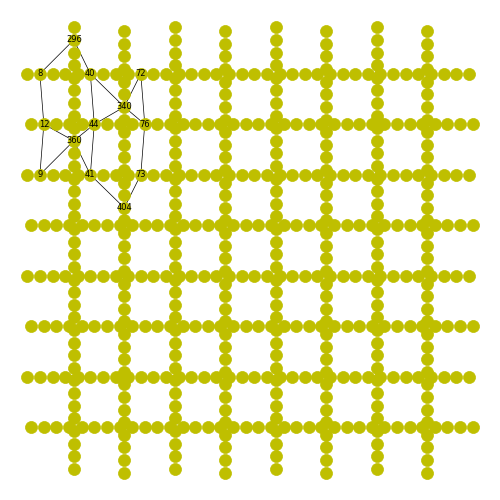

In [24]:
#this is layer 1
#define the 2 base hexagons and the 4 base triangles
hex1nodes=[296,40,44,360,12,8]
hex2nodes=[340,76,73,404,41,44]
hex1edges=[]
hex2edges=[]

for i in range(len(hex1nodes)):
    if i<len(hex1nodes)-1:
        hex1edges.append((hex1nodes[i],hex1nodes[i+1]))
    if i==len(hex1nodes)-1:
        hex1edges.append((hex1nodes[i],hex1nodes[0]))
        
for i in range(len(hex2nodes)):
    if i<len(hex2nodes)-1:
        hex2edges.append((hex2nodes[i],hex2nodes[i+1]))
    if i==len(hex2nodes)-1:
        hex2edges.append((hex2nodes[i],hex2nodes[0]))
    
tri1edges=[(40,340),(340,44),(44,40)]
tri2edges=[(72,76),(76,340),(340,72)]
tri3edges=[(44,41),(41,360),(360,44)]
tri4edges=[(12,360),(360,9),(9,12)]

hextriedges=hex1edges+hex2edges+tri1edges+tri2edges+tri3edges+tri4edges
hextriedges=list(set(hextriedges))

hextrinodes=[]
for tup in hextriedges:
    hextrinodes.append(tup[0])
    hextrinodes.append(tup[1])
hextrinodes=list(set(hextrinodes))

hextrilabels={}
for node in hextrinodes:
    hextrilabels.update({node:str(node)})

plt.ion()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"]=50

Kag=dnx.zephyr_graph(4,edge_list=hextriedges)
dnx.draw_zephyr(Kag,labels=hextrilabels,node_color='y')
plt.show()

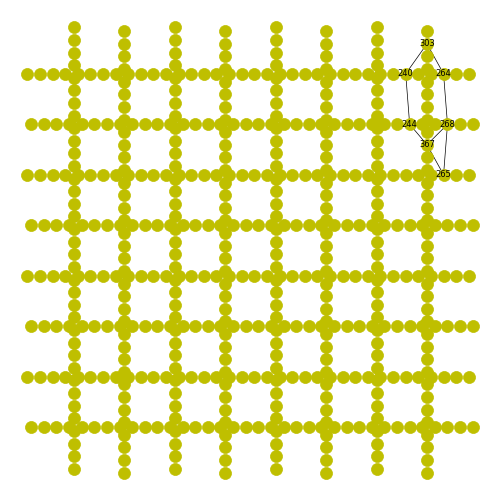

In [25]:
#this is the connection between layer 1 and layer 2
#define the 1 base hexagon and the 1 base triangle
hex3nodes=[303,240,244,367,268,264]
hex3edges=[]

for i in range(len(hex3nodes)):
    if i<len(hex3nodes)-1:
        hex3edges.append((hex3nodes[i],hex3nodes[i+1]))
    if i==len(hex3nodes)-1:
        hex3edges.append((hex3nodes[i],hex3nodes[0]))
    
tri5edges=[(268,367),(367,265),(265,268)]

#"con" denotes connection
hextriedges_con=hex3edges+tri5edges
hextriedges_con=list(set(hextriedges_con))

hextrinodes_con=[]
for tup in hextriedges_con:
    hextrinodes_con.append(tup[0])
    hextrinodes_con.append(tup[1])
hextrinodes_con=list(set(hextrinodes_con))

hextrilabels_con={}
for node in hextrinodes_con:
    hextrilabels_con.update({node:str(node)})

plt.ion()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"]=50

Kag=dnx.zephyr_graph(4,edge_list=hextriedges_con)
dnx.draw_zephyr(Kag,labels=hextrilabels_con,node_color='y')
plt.show()

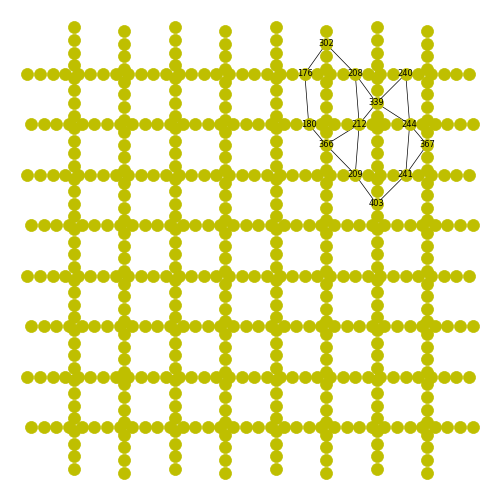

In [26]:
#this is layer 2
#define the 2 base hexagons and the 4 base triangles
hex4nodes=[339,212,209,403,241,244]
hex5nodes=[302,176,180,366,212,208]
hex4edges=[]
hex5edges=[]

for i in range(len(hex4nodes)):
    if i<len(hex4nodes)-1:
        hex4edges.append((hex4nodes[i],hex4nodes[i+1]))
    if i==len(hex4nodes)-1:
        hex4edges.append((hex4nodes[i],hex4nodes[0]))
        
for i in range(len(hex5nodes)):
    if i<len(hex5nodes)-1:
        hex5edges.append((hex5nodes[i],hex5nodes[i+1]))
    if i==len(hex5nodes)-1:
        hex5edges.append((hex5nodes[i],hex5nodes[0]))

tri6edges=[(244,241),(241,367),(367,244)]        
tri7edges=[(240,339),(339,244),(244,240)]
tri8edges=[(208,339),(339,212),(212,208)]
tri9edges=[(212,366),(366,209),(209,212)]

hextriedges2=hex4edges+hex5edges+tri6edges+tri7edges+tri8edges+tri9edges
hextriedges2=list(set(hextriedges2))

hextrinodes2=[]
for tup in hextriedges2:
    hextrinodes2.append(tup[0])
    hextrinodes2.append(tup[1])
hextrinodes2=list(set(hextrinodes2))

hextrilabels2={}
for node in hextrinodes2:
    hextrilabels2.update({node:str(node)})

plt.ion()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"]=50

Kag=dnx.zephyr_graph(4,edge_list=hextriedges2)
dnx.draw_zephyr(Kag,labels=hextrilabels2,node_color='y')
plt.show()

In [27]:
#redefine the base hexs and tris as arrays
hex1base = TuptoArray(hex1edges)
hex2base = TuptoArray(hex2edges)
hex3base = TuptoArray(hex3edges)
hex4base = TuptoArray(hex4edges)
hex5base = TuptoArray(hex5edges)
tri1base = TuptoArray(tri1edges)
tri2base = TuptoArray(tri2edges)
tri3base = TuptoArray(tri3edges)
tri4base = TuptoArray(tri4edges)
tri5base = TuptoArray(tri5edges)
tri6base = TuptoArray(tri6edges)
tri7base = TuptoArray(tri7edges)
tri8base = TuptoArray(tri8edges)
tri9base = TuptoArray(tri9edges)
#now we have a bunch of arrays that we can add to to create a larger lattice

# regs, embedding drawing

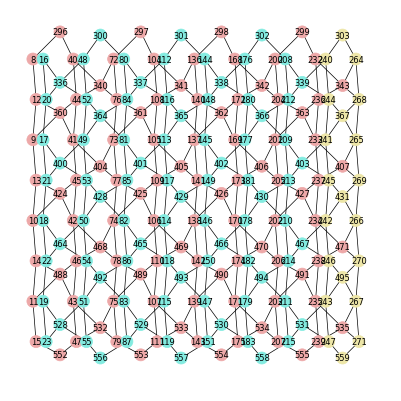

In [28]:
hex1reg,hex2reg,hex3reg,hex4reg,hex5reg,tri1reg,tri2reg,tri3reg,tri4reg,tri5reg,tri6reg,tri7reg,tri8reg,tri9reg=NxN_tile(N=4,fold=True)

allhexreg=np.array([hex1reg,hex2reg,hex3reg,hex4reg,hex5reg],dtype=object)
alltrireg=np.array([tri1reg,tri2reg,tri3reg,tri4reg,tri5reg,tri6reg,tri7reg,tri8reg,tri9reg],dtype=object)

layer1regs=hex1reg+hex2reg+tri1reg+tri2reg+tri3reg+tri4reg
connectionregs=hex3reg+tri5reg
layer2regs=hex4reg+hex5reg+tri6reg+tri7reg+tri8reg+tri9reg
allregs=layer1regs+connectionregs+layer2regs

layer1edges,layer1nodes=RegsToTups(layer1regs)
connectionedges,connectionnodes=RegsToTups(connectionregs)
layer2edges,layer2nodes=RegsToTups(layer2regs)
alledges,allnodes=RegsToTups(allregs)

layer1nodes=list(set(layer1nodes))
layer2nodes=list(set(layer2nodes))
connectionnodes=list(set(connectionnodes))

plt.ion()
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["figure.dpi"]=50

alllabels={}
for node in allnodes:
    alllabels.update({node:str(node)})

Zeph=dnx.zephyr_graph(4)
Kagall=dnx.zephyr_graph(4,edge_list=alledges)
Kag1=dnx.zephyr_graph(4,edge_list=layer1edges)
Kag2=dnx.zephyr_graph(4,edge_list=layer2edges)
Kagcon=dnx.zephyr_graph(4,edge_list=connectionedges)
Kag2andcon=dnx.zephyr_graph(4,edge_list=connectionedges+layer2edges)

allcolors=[]
for node in Kagall.nodes():
    if (node in layer1nodes and node in connectionnodes and node in layer2nodes):
        allcolors.append('#ede6a8')
    elif (node in layer1nodes and node in connectionnodes):
        allcolors.append('#ede6a8')
    elif (node in layer2nodes and node in connectionnodes):
        allcolors.append('#ede6a8')
    else:
        if node in layer1nodes:
            allcolors.append('#eda8a8')
        elif node in layer2nodes:
            allcolors.append('#83ebe0')
        elif node in connectionnodes:
            allcolors.append('#ede6a8')
        else:
            allcolors.append('none')

# allcolors=np.array([sorted(allnodes),allcolors])
    
dnx.draw_zephyr(
    Kagall,
    node_color=allcolors,
    labels=alllabels,
)
# dnx.draw_zephyr(Zeph)
# dnx.draw_zephyr(Kag1,node_color='#eda8a8',with_labels=True)
# dnx.draw_zephyr(Kag2,node_color='b',with_labels=True)
# dnx.draw_zephyr(Kag2andcon,node_color='#83ebe0',with_labels=True)
# plt.savefig('folded_kagome')
plt.show()

In [29]:
#alledges,allnodes=RegsToTups(allregs)
#this is the stuff that current


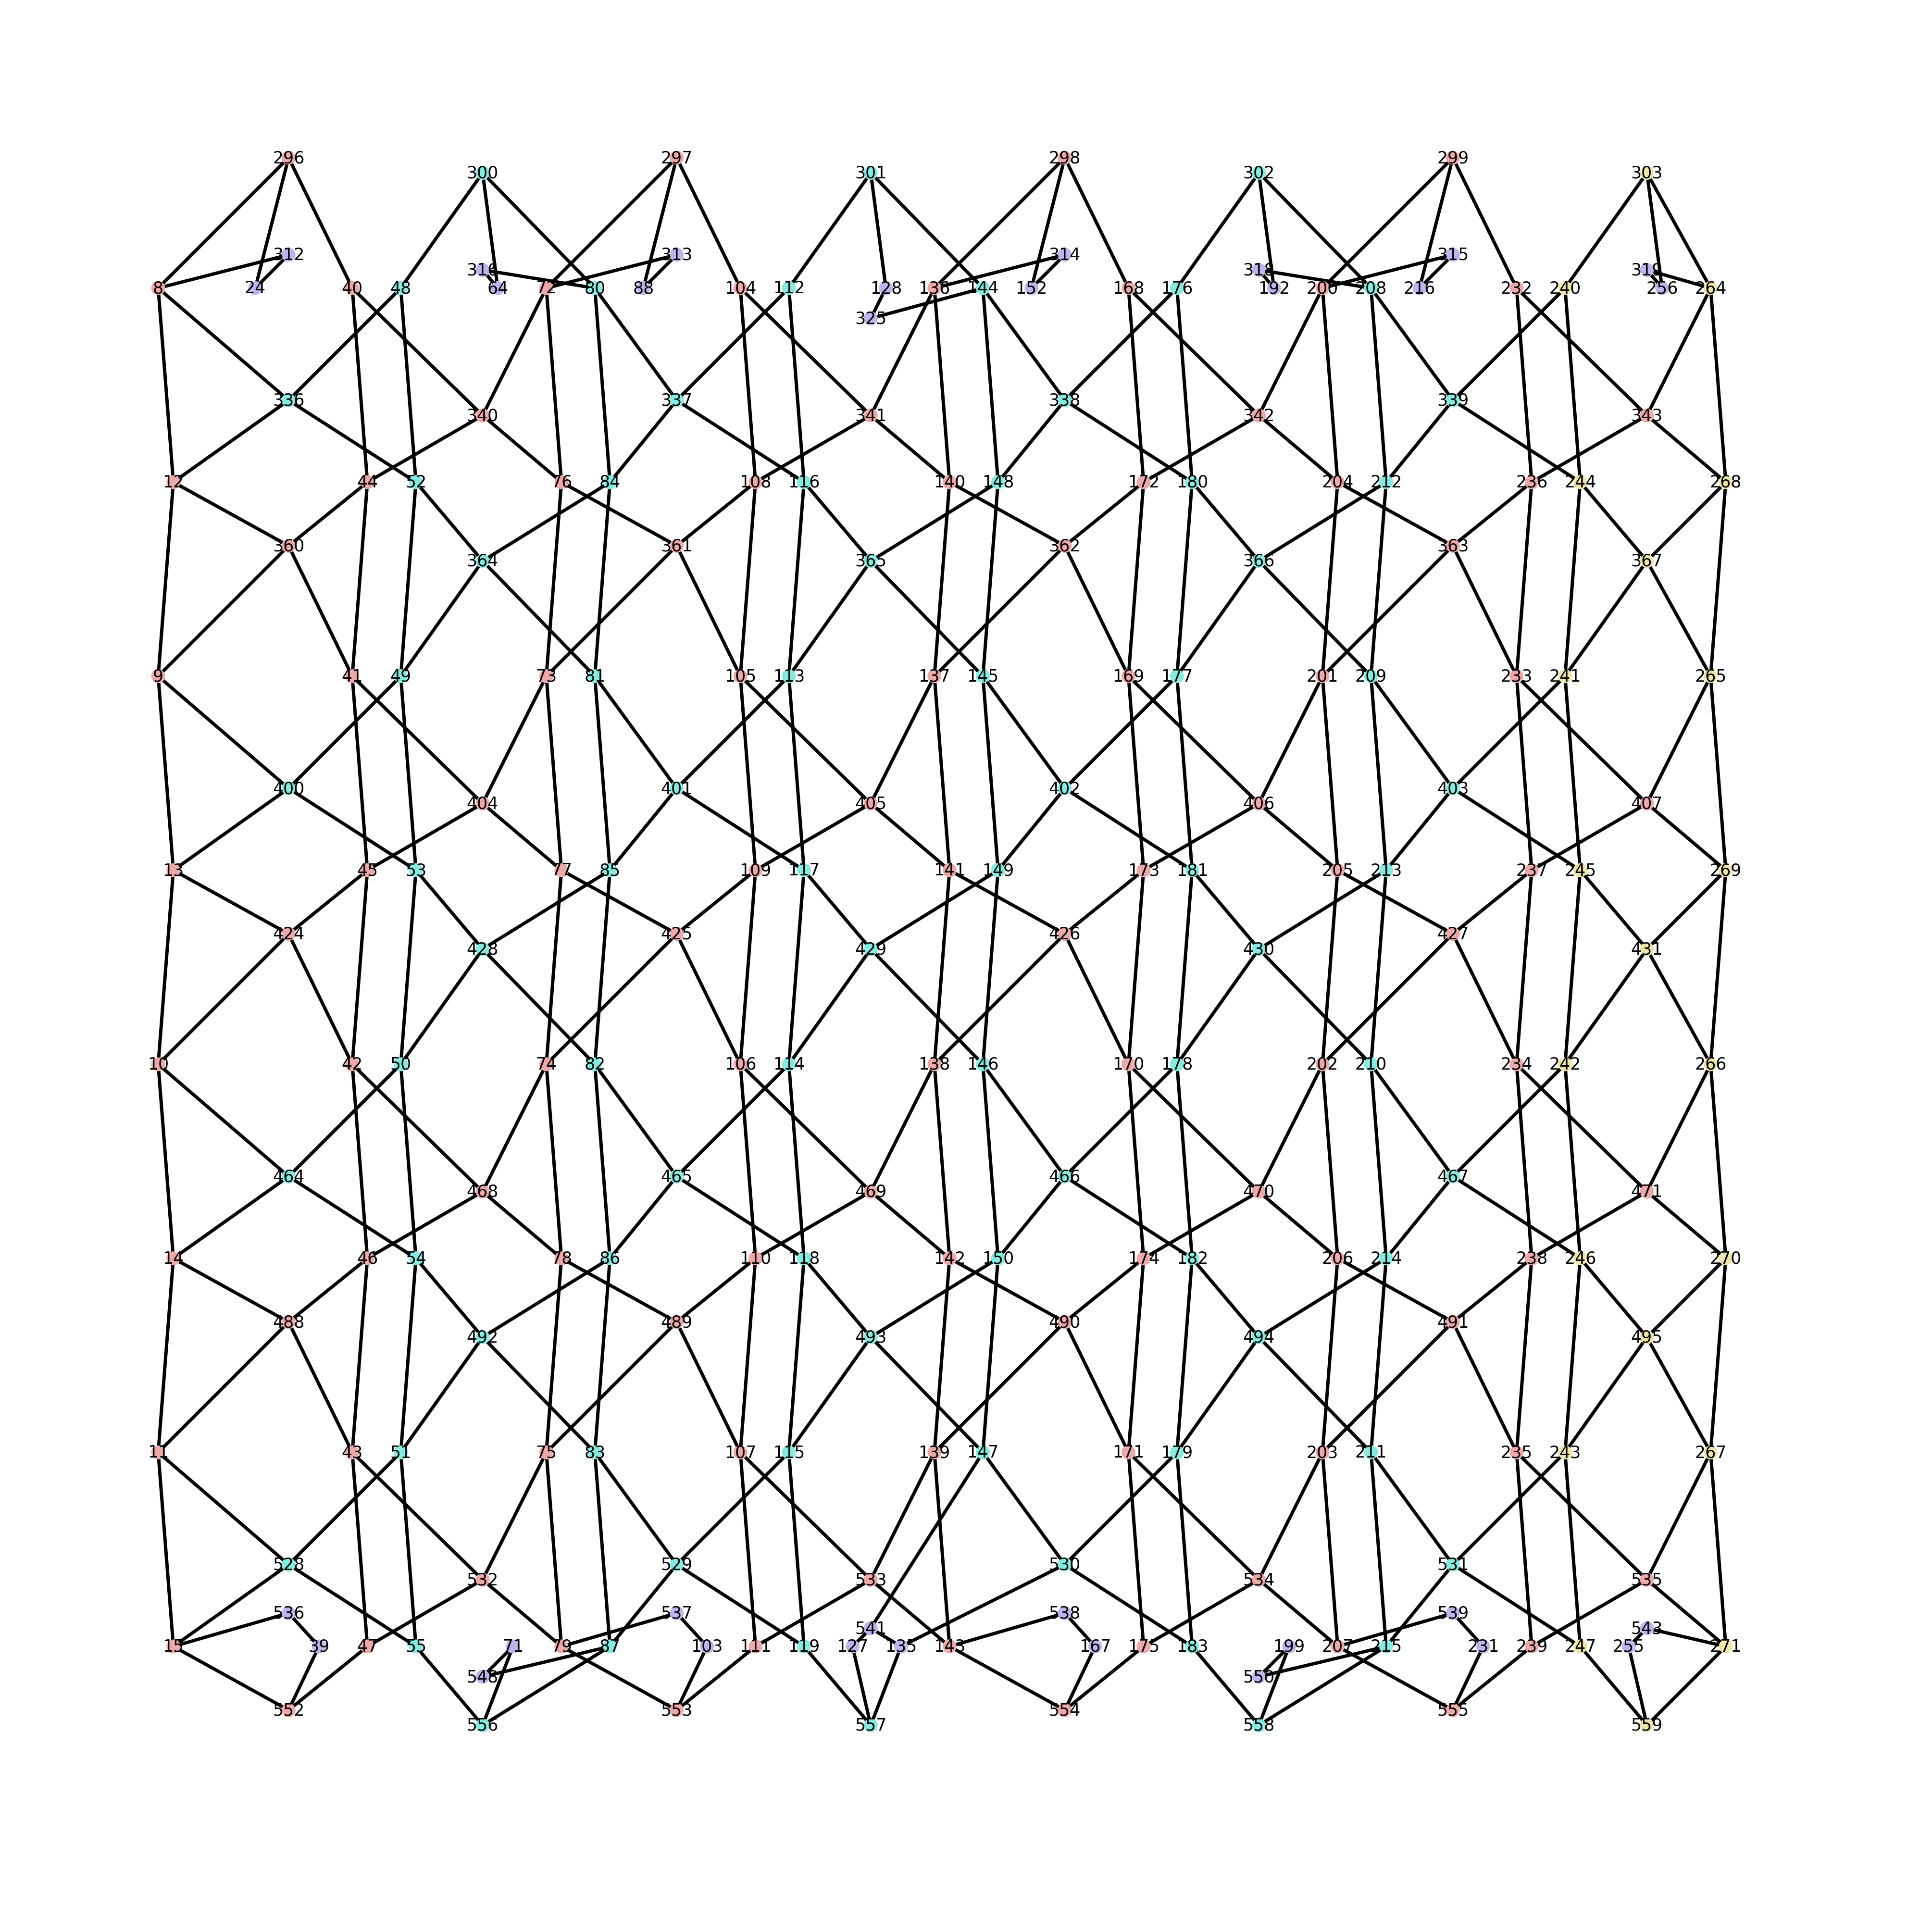

In [30]:
Kag_periodic = Kagall
to_delete = [16, 20, 17,21,18,22,19,23]
Kag_periodic.remove_nodes_from(to_delete)
to_add_edge = [(336,8), (336,12), (400,9), (400,13), (464,10), (464,14), (528,11), (528,15)]
for i in range(len(to_add_edge)):
    if to_add_edge[i] in sampler.edgelist:
        Kag_periodic.add_edge(*to_add_edge[i])
    elif Reverse(to_add_edge[i]) in sampler.edgelist:
        Kag_periodic.add_edge(*Reverse(to_add_edge[i]))
    else:
        print("Uh Oh you have a problem.")

#pre-handle the missing qubit 151
current_twochains = [(135,541)]
#remove 151 
to_delete = [151]
Kag_periodic.remove_nodes_from(to_delete)
#and add two chain (143 - 541)
to_add_missing = [(541,135), (557,135), (135, 530), (147,541)]
for i in range(len(to_add_missing)):
    if to_add_missing[i] in sampler.edgelist:
        Kag_periodic.add_edge(*to_add_missing[i])
    elif Reverse(to_add_missing[i]) in sampler.edgelist:
        Kag_periodic.add_edge(*Reverse(to_add_missing[i]))
    else:
        print("Uh Oh you have a problem.")

#add the new two chains for the triangles
to_add_triangles = []
to_add_triangles = [(24,312), (88,313), (152,314), (216,315), (319, 256), (318, 192), (128, 325), (64, 316), (536, 39), (537, 103), (538, 167), (539, 231), (543, 255), (550, 199), (71, 548)]
to_add_couplers_triangles = []
to_add_couplers_triangles = [(24,296), (312, 8), (313, 72), (88, 297), (314, 136), (152, 298), (216, 299), (315, 200), (319, 264), (256, 303), (318, 208), (192, 302), (325, 144), (128, 301), (64, 300), (316, 80),
(536, 15), (39, 552), (537, 79), (103, 553), (167, 554), (538, 143), (539, 207), (231, 555), (255, 559), (543, 271), (199, 558), (550, 215), (71, 556), (87, 548), (127, 541), (127, 557)]
to_all_add_triangles = to_add_triangles + to_add_couplers_triangles
for i in range(len(to_all_add_triangles)):
    if to_all_add_triangles[i] in sampler.edgelist:
        Kag_periodic.add_edge(*to_all_add_triangles[i])
    elif Reverse(to_all_add_triangles[i]) in sampler.edgelist:
        Kag_periodic.add_edge(*Reverse(to_all_add_triangles[i]))
    else:
        print("Uh Oh you have a problem.", to_all_add_triangles[i])

current_twochains = current_twochains + to_add_triangles

#take care of the coloring for two chains
added_twochains=[]
for coup in current_twochains:
    added_twochains.append(coup[0])
    added_twochains.append(coup[1])
added_twochains.append(127)
added_twochains=list(set(added_twochains))

plt.ion()
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["figure.dpi"]=500

allcolors=[]
alllabels={}
for node in Kag_periodic.nodes():
    check = 1
    if (node in layer1nodes and node in connectionnodes and node in layer2nodes):
        allcolors.append('#ede6a8')
    elif (node in layer1nodes and node in connectionnodes):
        allcolors.append('#ede6a8')
    elif (node in layer2nodes and node in connectionnodes):
        allcolors.append('#ede6a8')
    else:
        if node in layer1nodes:
            allcolors.append('#eda8a8')
        elif node in layer2nodes:
            allcolors.append('#83ebe0')
        elif node in connectionnodes:
            allcolors.append('#ede6a8')
        elif node in added_twochains:
            allcolors.append('#c1b4ed')
        else:
            check = 0
            allcolors.append('none')
    if check == 1:
        alllabels.update({node:str(node)})

#for node in Kagall.nodes():
#    if (node not in layer1nodes and node not in connectionnodes and node not in layer2nodes):
#        Kag_periodic.remove_node(node)

dnx.draw_zephyr(
    Kag_periodic,
    node_color=allcolors,
    labels=alllabels,
    node_size = 10,
    font_size = 5
)

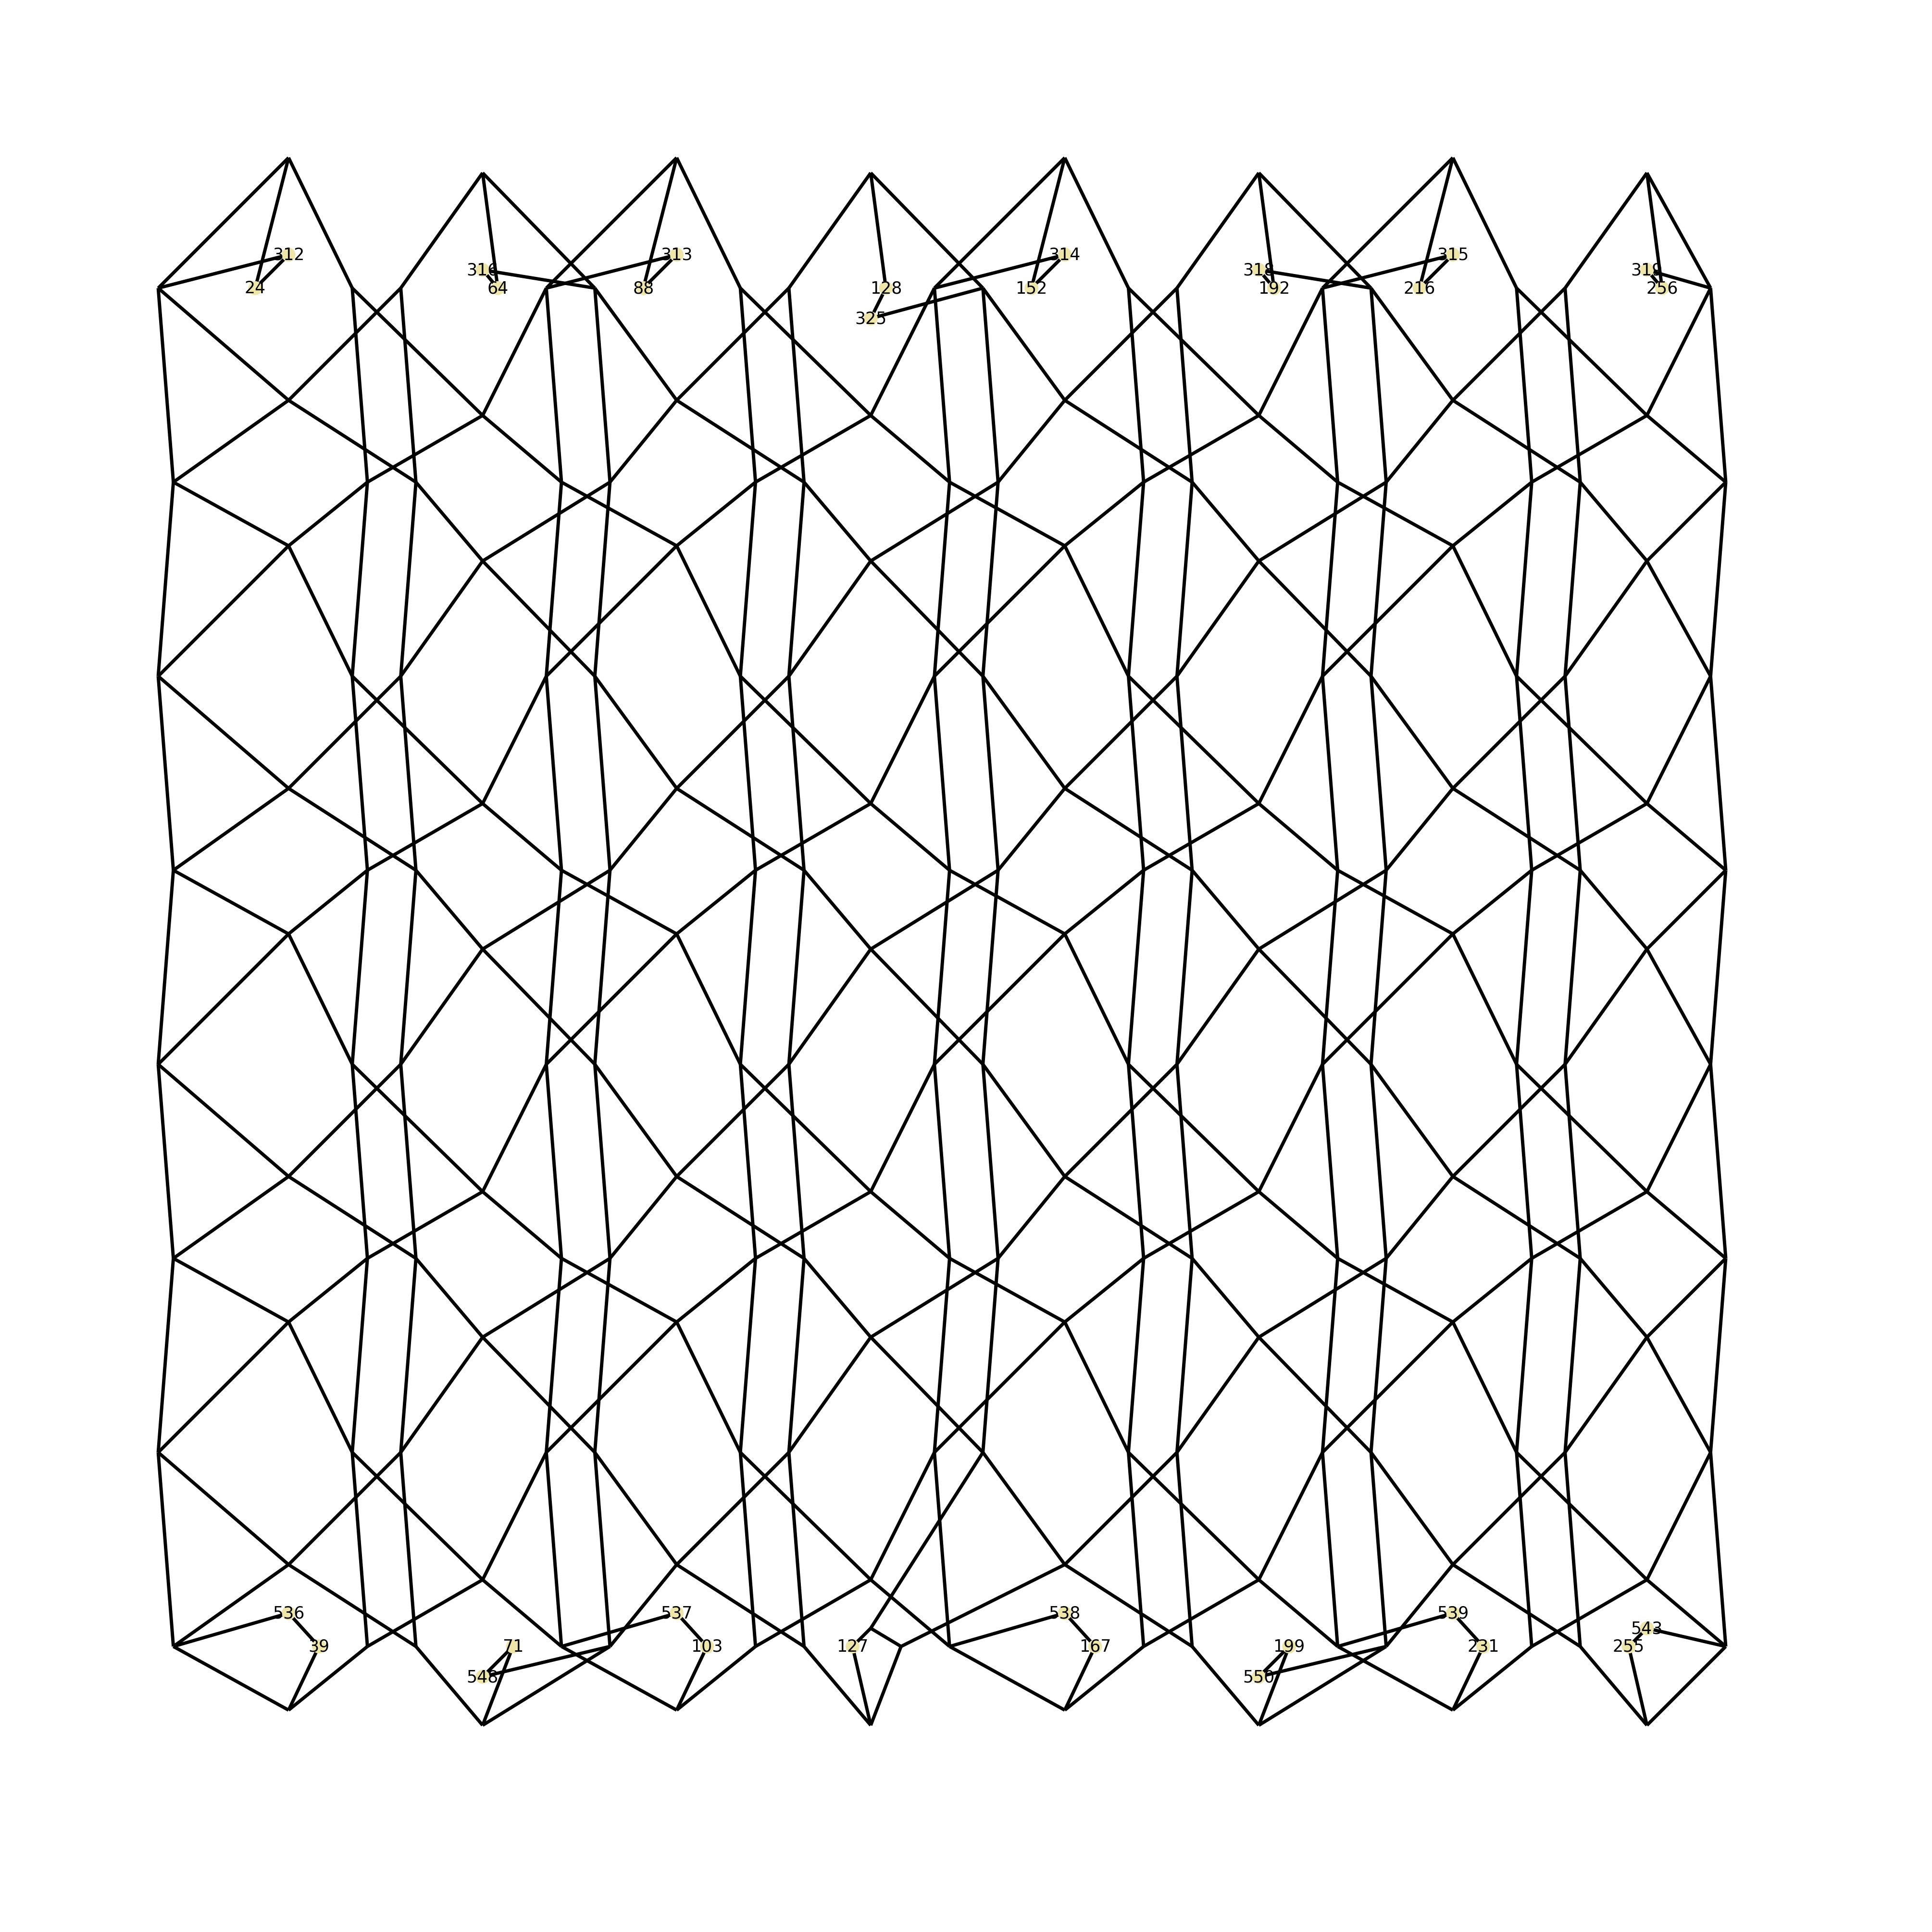

In [31]:
#plotting only the edges
edge_nodes = added_twochains
edge_nodes.remove(135)
edge_nodes.remove(541)

allcolors=[]
alllabels={}
for node in Kag_periodic.nodes():
    check = 1
    if node in edge_nodes:
        allcolors.append('#ede6a8')
    else:
        check = 0
        allcolors.append('none')
    if check == 1:
        alllabels.update({node:str(node)})

#for node in Kagall.nodes():
#    if (node not in layer1nodes and node not in connectionnodes and node not in layer2nodes):
#        Kag_periodic.remove_node(node)

dnx.draw_zephyr(
    Kag_periodic,
    node_color=allcolors,
    labels=alllabels,
    node_size = 10,
    font_size = 5
)

Making a simplified graph that is a reworked version of the periodic one - useful for the Fourier Transform

In [32]:
#make a graph with majority rule, for the fourier transform. 
#for all pre-imposed two-chains, remove the second one, reconnect to other sites
#then cut open the periodic boundary condition
simplify_Kag_graph = nx.Graph()
big_graph = Kag_periodic
all_edges_kag = [e for e in big_graph.edges()] 
all_nodes_kag = []
for m in big_graph.nodes:
    edges_to_it = big_graph.edges(m)
    if len(edges_to_it) > 0:
        all_nodes_kag.append(m)
        simplify_Kag_graph.add_node(m)
for e in all_edges_kag:
    simplify_Kag_graph.add_edge(*e)

#remove the end edges
for e in all_edges_kag:
    if e in to_add_edge:
        simplify_Kag_graph.remove_edge(*e)
    elif Reverse(e) in to_add_edge:
        simplify_Kag_graph.remove_edge(*Reverse(e))

#remove the second site of the two chains, and replug the graph
to_remove = []
to_add = []
node_remove = []
for twoch in current_twochains:
    #print("treating this 2chain", twoch)
    node_remove.append(twoch[1])
    temp_edges_to_modify = simplify_Kag_graph.edges(twoch[1])
    #print(temp_edges_to_modify)
    for edge in temp_edges_to_modify:
        #print("Modifying this edges", edge)
        to_remove.append(edge)
        if edge != twoch and edge != Reverse(twoch):
            new_link = twoch[1]
            for m in range(2):
                if edge[m] != twoch[1]:
                    new_link = edge[m]
            edge_add = (twoch[0], new_link)
            to_add.append(edge_add)


simplify_Kag_graph.remove_edges_from(to_remove)
simplify_Kag_graph.add_edges_from(to_add)
simplify_Kag_graph.remove_nodes_from(node_remove)

#get the "relaxed" graph for the Zephyr kagome lattice
#this is close to the ideal graph
#test, planar_embed = nx.check_planarity(simplify_Kag_graph)
#pos = nx.combinatorial_embedding_to_pos(planar_embed, fully_triangulate=True)
#pos=nx.spring_layout(simplify_Kag_graph, dim = 2, k=10,iterations = 1000, pos = pos, scale = 40)
#nx.draw(simplify_Kag_graph, pos, node_size = 25)


In [33]:
#test, planar_embed = nx.check_planarity(simplify_Kag_graph)
#pos = nx.combinatorial_embedding_to_pos(planar_embed, fully_triangulate=True)
#pos=nx.spring_layout(simplify_Kag_graph, dim = 2, k=10,iterations = 1000, pos = pos, scale = 40)
#nx.draw(simplify_Kag_graph, pos, node_size = 25)

In [34]:
nodecheck = (319, 256)
nodecheck in sampler.edgelist or Reverse(nodecheck) in sampler.edgelist

True

We need to hand-select the top and down edge boundaries. A function could probably search for those, but for now that's too complex. We hard code those list of nodes by hand. 

In [35]:
#these are A sites that *should* connect to B and C sites
top_edge = [24, 312, 64, 316, 88, 313, 325, 128, 152, 314, 318, 192, 315, 216, 256, 319] 
#these are B sites that *should* connect to A and C sites
bottom_edge = [255, 543, 231, 539, 199, 550, 167, 538, 127, 103, 537, 71, 548, 39, 536]
#then there are sites with only three neighbors:
#on the top edge, these are connectect to B sites
top_2nd_edge = [296, 40, 297, 104, 298, 168, 299, 232, 303, 240, 302, 176, 301, 112, 300, 48]
#on the bottom edge, these are connectect to A sites
bottom_2nd_edge = [552, 47, 553, 111, 554, 175, 555, 239, 559, 247, 558, 183, 557, 119, 556, 55]
#tuning the h_i at these sites "completes" the periodic boundary conditions on the lattice. 

# Adaptative mean-field boundary conditions

First, we create the full list of couplers and nodes that are active on the QPU, where missing couplers have been fixed through "surgery". The list "all_measure" corresponds to which qubits we need to measure to extract the magnetization (this follows a majority rule on each chain, and assumes that there is no chain break).

In [36]:
#get a new list of edges and nodes, as well as current two chains
alledges = list(Kag_periodic.edges)
allnodes = []
for node in Kag_periodic.nodes:
    check = False
    for edge in Kag_periodic.edges:
        if node in edge:
            check = True
    if check == True:
        allnodes.append(node)
allnodes = set(allnodes)

h1 = 1
jafm = 1.0
k2 = -2.0
h2 = 0.5 * h1

#fix the lattice with surgery for missing couplers
final_coups, final_nodes, twochains, twochain_nodes, onechain_nodes, missingqs, goodtogo = checks_with_twochains(
    alledges, allnodes, current_twochains)

#modify top_2nd and bottom_2nd so that they include 2 chains that have been included through surgery

#measure all onechain_nodes as well as one out of each twochains
dominant_qubit = []
for edge in twochains:
    dominant_qubit.append(edge[0])
all_measure = onechain_nodes +  dominant_qubit #this is the list of who should be measured.

The lists for the top and bottom 2nd edge (sites that have one missing coupler) need to be modified.

In [37]:
#check if you need to add any node to the top and bottom second edge sites that might become chains in the surgery process. 
for edge_twochain in twochains:
    if edge_twochain[0] in top_2nd_edge and edge_twochain[1] not in top_2nd_edge:
        top_2nd_edge.append(edge_twochain[1])
    elif edge_twochain[0] not in top_2nd_edge and edge_twochain[1] in top_2nd_edge:
        top_2nd_edge.append(edge_twochain[2])
    
    if edge_twochain[0] in bottom_2nd_edge and edge_twochain[1] not in bottom_2nd_edge:
        bottom_2nd_edge.append(edge_twochain[1])
    elif edge_twochain[0] not in bottom_2nd_edge and edge_twochain[1] in bottom_2nd_edge:
        bottom_2nd_edge.append(edge_twochain[2])
#indeed, bottom 2nd edge added one index to it.
    

A sample run, with no correction on the boundary fields.

In [38]:
#set the lists of modified boundary longitudinal fields, as well as the list of nodes to modify
all_h_mod = [h1,h1,h1,h1]
all_nodes_modified = [top_edge, top_2nd_edge, bottom_edge, bottom_2nd_edge]
#new h dictionary is set
hdict = set_hs_with_edge(final_nodes,onechain_nodes,twochain_nodes,all_nodes_modified, h1, all_h_mod)

#do a run
num_reads = 200
response = sampler.sample_ising(h = hdict, J=final_coups,
                                            num_reads=num_reads,
                                            annealing_time=100, num_spin_reversal_transforms = 10)
#dwave.inspector.show(response)

Prepare lists of sites to measure the A,B and C sublattice Z-magnetizations

In [39]:
array_test = np.load("./data/sublattices.npy", allow_pickle = True).flat[0]
all_variables = np.array(response.variables)
indices_measure_A = []
indices_measure_B = []
indices_measure_C = []
#exclude the edge nodes from the A,B,C averages
nodes_to_exclude = top_edge + top_2nd_edge + bottom_edge + bottom_2nd_edge
#exclude none
#nodes_to_exclude = []
for key in array_test.keys():
    key_in_measure = np.where(all_variables == key)[0][0]
    if key_in_measure not in nodes_to_exclude:
        if array_test[key] == "A":
            indices_measure_A.append(key_in_measure)
        elif array_test[key] == "B":
            indices_measure_B.append(key_in_measure)
        elif array_test[key] == "C":
            indices_measure_C.append(key_in_measure)


Iterative process to set the new boundary conditions. 200 anneals are done, A,B,C magnetizations are extracted and then fed back into the new h_dict. 

It is not exactly clear yet what should be the end condition for this loop. For the sublattice magnetizations to be static, i.e. not change iteration after iteration?

In [40]:
num_steps = 10
num_reads = 200
measure_Z_sublatt_A = 0.0
measure_Z_sublatt_B = 0.0
measure_Z_sublatt_C = 0.0
record_mag_A = []
record_mag_B = []
record_mag_C = []
for k in range(1, num_steps):
    temp_A = 0.0
    temp_B = 0.0
    temp_C = 0.0

    print("step ", k)
    print("avg Mag on A sublattice: ", measure_Z_sublatt_A)
    print("avg Mag on B sublattice: ", measure_Z_sublatt_B)
    print("avg Mag on C sublattice: ", measure_Z_sublatt_C)
    print("\n")

    #hdict = set_hs(final_nodes, onechain_nodes, twochain_nodes, h1, h2)
    all_h_mod = [h1 + jafm*(measure_Z_sublatt_B + measure_Z_sublatt_C),h1 + jafm*(measure_Z_sublatt_A + measure_Z_sublatt_C), h1 + jafm*measure_Z_sublatt_B, h1 + jafm*measure_Z_sublatt_A]
    all_nodes_modified = [top_edge, bottom_edge, top_2nd_edge, bottom_2nd_edge]
    hdict = set_hs_with_edge(final_nodes,onechain_nodes,twochain_nodes,all_nodes_modified, h1, all_h_mod)

    response = sampler.sample_ising(h = hdict, J=final_coups,
                                            num_reads=num_reads,
                                            annealing_time=100, num_spin_reversal_transforms = 10, answer_mode = "raw")

    for j in range(num_reads):
        temp_A += np.mean(response.record[j][0][indices_measure_A])/num_reads
        temp_B += np.mean(response.record[j][0][indices_measure_B])/num_reads
        temp_C += np.mean(response.record[j][0][indices_measure_C])/num_reads
    record_mag_A.append(temp_A)
    record_mag_B.append(temp_B)
    record_mag_C.append(temp_C)
    measure_Z_sublatt_A = np.mean(record_mag_A)
    measure_Z_sublatt_B = np.mean(record_mag_B)
    measure_Z_sublatt_C = np.mean(record_mag_C)
    

step  1
avg Mag on A sublattice:  0.0
avg Mag on B sublattice:  0.0
avg Mag on C sublattice:  0.0


step  2
avg Mag on A sublattice:  -0.3344117647058824
avg Mag on B sublattice:  -0.33783333333333376
avg Mag on C sublattice:  -0.2843548387096776


step  3
avg Mag on A sublattice:  -0.2843382352941176
avg Mag on B sublattice:  -0.3249166666666671
avg Mag on C sublattice:  -0.30516129032258077


step  4
avg Mag on A sublattice:  -0.28872549019607846
avg Mag on B sublattice:  -0.32333333333333375
avg Mag on C sublattice:  -0.2897849462365592


step  5
avg Mag on A sublattice:  -0.27238970588235295
avg Mag on B sublattice:  -0.3221250000000003
avg Mag on C sublattice:  -0.2969758064516129


step  6
avg Mag on A sublattice:  -0.2736470588235294
avg Mag on B sublattice:  -0.32170000000000026
avg Mag on C sublattice:  -0.28877419354838707


step  7
avg Mag on A sublattice:  -0.27441176470588236
avg Mag on B sublattice:  -0.31875000000000026
avg Mag on C sublattice:  -0.2851075268817204


ste

# other stuff to measure edge, bulk and total magnetization

In [41]:
to_measure_edge = []
for edge in current_twochains:
    to_measure_edge.append(edge[0])
to_measure_edge.remove(135)
to_measure_edge.append(127)
#these are all the edge sites

index_to_measure_edge = []
for i in range(len(response.variables)):
    if response.variables[i] in to_measure_edge:
        index_to_measure_edge.append(i)

index_to_measure_bulk = []
for i in range(len(response.variables)):
    if response.variables[i] in all_measure and response.variables[i] not in to_measure_edge:
        index_to_measure_bulk.append(i)

index_to_measure = []
for i in range(len(response.variables)):
    if response.variables[i] in all_measure:
        index_to_measure.append(i)

E_cutoff = - 100
all_measures_z_bulk = []
for j in range(200):
    if response.record[j][1] < E_cutoff:
        all_measures_z_bulk.append(np.mean(response.record[j][0][index_to_measure_bulk]))

print("avg Z magnetization bulk: ", np.mean(all_measures_z_bulk))

# measure the edge sites magnetization:

all_measures_z_edge = []
for j in range(200):
    all_measures_z_edge.append(np.mean(response.record[j][0][index_to_measure_edge]))

difference = []
for j in range(200):
    difference.append(np.abs(np.mean(response.record[j][0][index_to_measure]) - np.mean(response.record[j][0][index_to_measure_edge])))

print("avg Z magnetization on edge: ", np.mean(all_measures_z_edge))
print("avg difference bulk vs edge in a given sample:")
print(np.mean(difference), np.var(difference))


E_cutoff = - 100
all_measures_z = []
for j in range(200):
    if response.record[j][1] < E_cutoff:
        all_measures_z.append(np.mean(response.record[j][0][index_to_measure]))
print("total avg mag_z ", np.mean(all_measures_z))


avg Z magnetization bulk:  -0.2764000000000001
avg Z magnetization on edge:  -0.49625
avg difference bulk vs edge in a given sample:
0.23800925925925923 0.019471277006172842
total avg mag_z  -0.2926851851851852


Store last configuration (best energy) for plotting purposes

In [42]:
all_energies = []
for i in range(num_reads):
    all_energies.append(response.record[i][1])

best_array = response.record[np.argmin(all_energies)][0]
qubit_variables = np.array(response.variables)
#make as dict
best_array_dict = {}
for j in range(len(best_array)):
    best_array_dict.update({qubit_variables[j]:best_array[j]})

# Plot a given configuration

In [43]:
final_qubit_dictionary = np.load("./data/dict_qbit_to_lattice_periodic.npy", allow_pickle=True).flat[0]

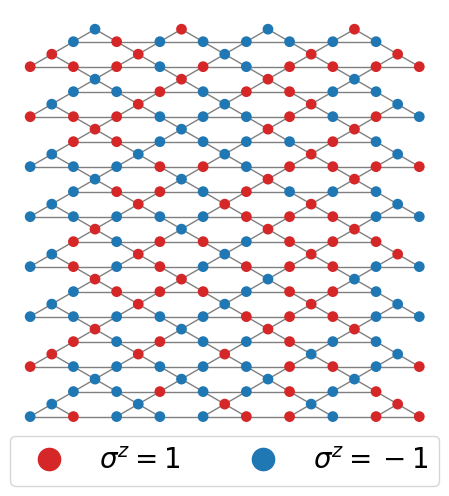

In [44]:
#plot the Kagome lattice graph for a generic lattice
#--- 1 -- 
#make a generic response
test_array = np.ones(len(final_qubit_dictionary))
fm_to_disorder = 1.0 
#1.0 is a random configuration
#0.0 is all -1
for i in range(len(test_array)):
    if np.random.rand() < fm_to_disorder:
        test_array[i] = 2*np.random.randint(2) - 1

test_response_qubits = np.array([k for k in final_qubit_dictionary.keys()])
qubits_val = [[], []]
for i in range(len(final_qubit_dictionary)):
    if test_array[i] == 1.0:
        qubits_val[0].append(test_response_qubits[i])
    if test_array[i] == -1.0:
        qubits_val[1].append(test_response_qubits[i])

#draw the graph with the specific nodes in red or blue

plt.ion()
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["figure.dpi"]=100

#nx.draw(simplify_Kag_graph, final_qubit_dictionary)
# nodes
ColorLegend = {r'$\sigma^z = 1$' : "tab:red", r'$\sigma^z = -1$' : "tab:blue"}
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in ColorLegend:
    ax.plot([0],[1.5],'o', markersize = 16, color=ColorLegend[label],label=label)
ax.plot([0], [1.5], 'o', markersize = 20, markerfacecolor='white', markeredgecolor='white', label='')

options = {"edgecolors": "none", "node_size": 60, "alpha": 1.0}
nx.draw_networkx_nodes(simplify_Kag_graph, final_qubit_dictionary, 
nodelist=qubits_val[0], node_color="tab:red", **options, ax=ax)
nx.draw_networkx_nodes(simplify_Kag_graph, final_qubit_dictionary, 
nodelist=qubits_val[1], node_color="tab:blue", **options, ax=ax)

# edges
nx.draw_networkx_edges(simplify_Kag_graph, final_qubit_dictionary, width=1.0, alpha=0.5, ax=ax)
# Create a custom legend with colored markers

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(bbox_to_anchor =(0.5,-0.15),loc='lower center', ncol=2, fontsize = 20)

plt.tight_layout()
plt.axis("off")
plt.show()

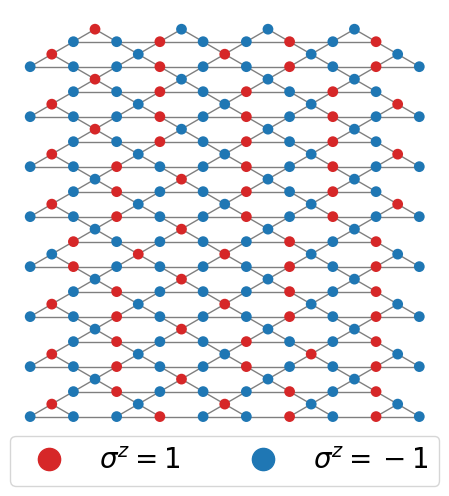

In [45]:
#plot the Kagome lattice graph for the extracted array
qubits_val = [[], []]
for key in final_qubit_dictionary.keys():
    if best_array_dict[key] == 1.0:
        qubits_val[0].append(key)
    if best_array_dict[key] == -1.0:
        qubits_val[1].append(key)

#draw the graph with the specific nodes in red or blue

plt.ion()
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["figure.dpi"]=100

#nx.draw(simplify_Kag_graph, final_qubit_dictionary)
# nodes
ColorLegend = {r'$\sigma^z = 1$' : "tab:red", r'$\sigma^z = -1$' : "tab:blue"}
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in ColorLegend:
    ax.plot([0],[1.5],'o', markersize = 16, color=ColorLegend[label],label=label)
ax.plot([0], [1.5], 'o', markersize = 20, markerfacecolor='white', markeredgecolor='white', label='')

options = {"edgecolors": "none", "node_size": 60, "alpha": 1.0}
nx.draw_networkx_nodes(simplify_Kag_graph, final_qubit_dictionary, 
nodelist=qubits_val[0], node_color="tab:red", **options, ax=ax)
nx.draw_networkx_nodes(simplify_Kag_graph, final_qubit_dictionary, 
nodelist=qubits_val[1], node_color="tab:blue", **options, ax=ax)

# edges
nx.draw_networkx_edges(simplify_Kag_graph, final_qubit_dictionary, width=1.0, alpha=0.5, ax=ax)
# Create a custom legend with colored markers

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(bbox_to_anchor =(0.5,-0.15),loc='lower center', ncol=2, fontsize = 20)

plt.tight_layout()
plt.axis("off")
plt.show()

# Do S(q) Fourier Transform 

First, some function definitions.

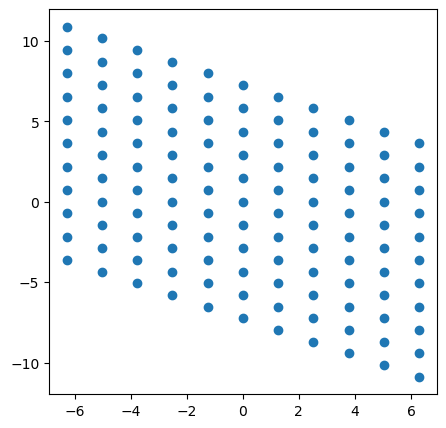

In [46]:
def momentum_grid_kagome(N):
        # Reciprocal lattice vectors
        b1 = 2*np.pi * np.array([1, -1/np.sqrt(3)])
        b2 = 2*np.pi * np.array([0, 2/np.sqrt(3)])

        # Generate a mesh of points in the range -0.5 to 0.5 for each reciprocal lattice vector
        points1 = np.linspace(-1, 1, N)
        points2 = np.linspace(-1, 1, N)
        mesh1, mesh2 = np.meshgrid(points1, points2)

        m1 = mesh1.flatten()
        m2 = mesh2.flatten()
        kx_vals = np.zeros(N**2)
        ky_vals = np.zeros(N**2)
        for i in range(N**2):
                kx_vals[i] = m1[i]*b1[0] + m2[i]*b2[0]
                ky_vals[i] = m1[i]*b1[1] + m2[i]*b2[1]

        total_K = []
        for i in range(N**2):
                total_K.append([kx_vals[i], ky_vals[i]])
        total_K = np.array(total_K)
        kx_vals = kx_vals.reshape(N,N)
        ky_vals = ky_vals.reshape(N,N)



        return total_K, kx_vals, ky_vals

def momentum_grid(N):
        # Reciprocal lattice vectors
        b1 = 2*np.pi * np.array([1,0])
        b2 = 2*np.pi * np.array([0, 1])

        # Generate a mesh of points in the range -0.5 to 0.5 for each reciprocal lattice vector
        points1 = np.linspace(-0.5, 0.5, N)
        points2 = np.linspace(-0.5, 0.5, N)
        mesh1, mesh2 = np.meshgrid(points1, points2)

        m1 = mesh1.flatten()
        m2 = mesh2.flatten()
        kx_vals = np.zeros(N**2)
        ky_vals = np.zeros(N**2)
        for i in range(N**2):
                kx_vals[i] = m1[i]*b1[0] + m2[i]*b2[0]
                ky_vals[i] = m1[i]*b1[1] + m2[i]*b2[1]

        total_K = []
        for i in range(N**2):
                total_K.append([kx_vals[i], ky_vals[i]])
        total_K = np.array(total_K)
        kx_vals = kx_vals.reshape(N,N)
        ky_vals = ky_vals.reshape(N,N)



        return total_K, kx_vals, ky_vals


#plot the scatter of the kx, ky points that have to be run over
total_K, kx_vals, ky_vals = momentum_grid_kagome(11)
plt.scatter(kx_vals, ky_vals)


Calculate the spin-spin structure factor <\sigma_i \sigma_j> - the very hard way! These cells are no longer needed as the double sum is very slow.

In [47]:
total_K, kx_vals, ky_vals = momentum_grid_kagome(11)

structure_factor = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
S2_spin = np.zeros(len(total_K))

response_analyzed = best_array_dict

for kp in range(len(total_K)):
    val = 0
    for q1 in final_qubit_dictionary.keys():
        for q2 in final_qubit_dictionary.keys():
            kpoint = total_K[kp]
            r1 = final_qubit_dictionary[q1]
            r2 = final_qubit_dictionary[q2]
            rdist = r1 - r2
            val += np.exp(1j*np.dot(kpoint, rdist))*response_analyzed[q1]*response_analyzed[q2]
    val = val/len(final_qubit_dictionary)
    structure_factor[kp] = val
    S2_spin[kp] = abs(val)



Text(0, 0.5, '$K_y$')

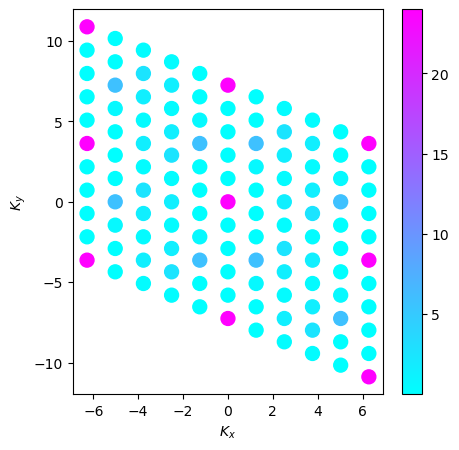

In [48]:
#norm = plt.Normalize(0,len(test_response_qubits))
cmap = plt.cm.get_cmap('cool')
plt.scatter(kx_vals, ky_vals, s=100, c=S2_spin, cmap=cmap)
plt.colorbar()
plt.xlabel(r'$K_x$')
plt.ylabel(r'$K_y$')

S(q) as in \sum_i e^{ik*r_i} s_i, for a given configuration

In [49]:
total_K, kx_vals, ky_vals = momentum_grid_kagome(40)

#structure_factor = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
S2_spin = np.zeros(len(total_K))

#response_analyzed = best_array_dict
response_analyzed = {}
response_array = response.record[100][0]
for j in range(len(response_array)):
    response_analyzed.update({qubit_variables[j]:response_array[j]})
avg = 0.0
calculate_avg = False
if calculate_avg == True:
    for q1 in final_qubit_dictionary.keys():
        avg += response_analyzed[q1]
    avg = avg / len(final_qubit_dictionary)

for kp in range(len(total_K)):
    val = 0
    for q1 in final_qubit_dictionary.keys():
        kpoint = total_K[kp]
        r1 = final_qubit_dictionary[q1]
        val += np.exp(1j*np.dot(kpoint, r1))*(response_analyzed[q1] - avg)
    val = val/len(final_qubit_dictionary)
    S2_spin[kp] = abs(val)



Text(0, 0.5, '$K_y$')

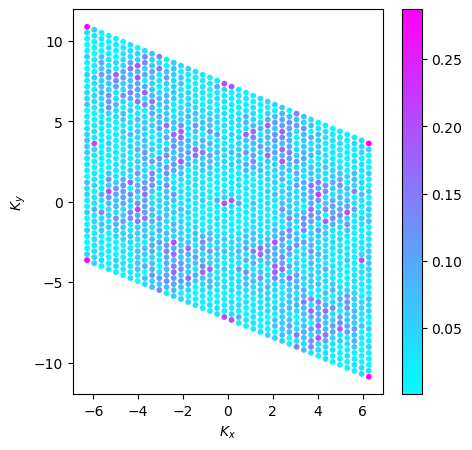

In [50]:
#norm = plt.Normalize(0,len(test_response_qubits))
cmap = plt.cm.get_cmap('cool')
plt.scatter(kx_vals, ky_vals, s=10, c=S2_spin, cmap=cmap)
plt.colorbar()
plt.xlabel(r'$K_x$')
plt.ylabel(r'$K_y$')

Average over all the available configurations: this is needed for the full structure factor

In [51]:
def Sq_for_record(all_record_configs, qubit_dictionary, qubit_variables, L_Kpoints):
    #L_Kpoints needs to be odd to see the q=0 component

    total_K, kx_vals, ky_vals = momentum_grid_kagome(L_Kpoints)

    structure_factor = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    structure_factor_mK = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    S_spin = np.zeros(len(total_K))
    S2_spin = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))

    num_reads = len(all_record_configs)

    for k in range(num_reads):
        response_analyzed = {}
        for j in range(len(response_array)):
            response_analyzed.update({qubit_variables[j]:all_record_configs[k][j]})
        avg = 0.0
        #calculate_avg = False
        #if calculate_avg == True:
        #    for q1 in qubit_dictionary.keys():
        #        avg += response_analyzed[q1]
        #    avg = avg / len(qubit_dictionary)

        for kp in range(len(total_K)):
            val_K = 0
            val_mK = 0
            for q1 in qubit_dictionary.keys():
                kpoint = total_K[kp]
                r1 = qubit_dictionary[q1]
                val_K += np.exp(1j*np.dot(kpoint, r1))*(response_analyzed[q1])
                val_mK += np.exp(-1j*np.dot(kpoint, r1))*(response_analyzed[q1])
            val_K = val_K/len(qubit_dictionary)
            val_mK = val_mK/len(qubit_dictionary)
            structure_factor += val_K
            structure_factor_mK += val_mK
            S_spin[kp] += abs(val_K)
            S2_spin[kp] += val_K*val_mK
        if k % 10 == 0:
            print("Done with reads: ", k)

    structure_factor = structure_factor / num_reads
    structure_factor_mK = structure_factor / num_reads
    S_spin = S_spin / num_reads
    S2_spin = S2_spin / num_reads

    return total_K, kx_vals, ky_vals, S_spin, S2_spin, structure_factor, structure_factor_mK
    

In [52]:
all_record_configs = np.array([response.record[k][0] for k in range(num_reads)])
numKpoints = 31
total_K, kx_vals, ky_vals, S_spin, S2_spin, structure_factor, structure_factor_mK = Sq_for_record(all_record_configs, final_qubit_dictionary, qubit_variables, numKpoints)

Done with reads:  0
Done with reads:  10
Done with reads:  20
Done with reads:  30
Done with reads:  40
Done with reads:  50
Done with reads:  60
Done with reads:  70
Done with reads:  80
Done with reads:  90
Done with reads:  100
Done with reads:  110
Done with reads:  120
Done with reads:  130
Done with reads:  140
Done with reads:  150
Done with reads:  160
Done with reads:  170
Done with reads:  180
Done with reads:  190


Text(0.5, 1.0, '$S(q)$, with 1st Brillouin Zone')

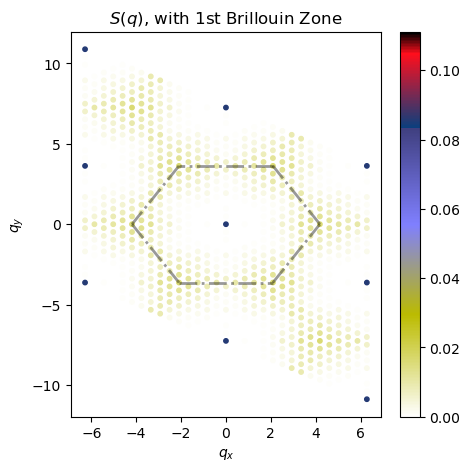

In [53]:
norm = plt.Normalize(0,(1/3)**2)
cmap = plt.cm.get_cmap('gist_stern_r')
#finalSQ = np.absolute(S2_spin) - np.absolute(structure_factor)*np.absolute(structure_factor_mK)
finalSQ_spin = np.absolute(S2_spin)
#finalSQ = final_spin_Q2 - final_spin_Q**2
plt.scatter(kx_vals, ky_vals, s=10, c=finalSQ_spin, cmap=cmap, norm = norm)
plt.colorbar()
theta_list = [2*np.pi*i/6 for i in range(7)]
lside = 4*np.pi/3
for j in range(6):
    plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])],
     [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)

plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
plt.title(r'$S(q)$, with 1st Brillouin Zone')

Interpolation Scheme

In [54]:
from scipy.interpolate import griddata
xlim = np.linspace(-2*np.pi, 2*np.pi, 100)
ylim = np.linspace(-2*np.pi, 2*np.pi, 100)
#xlim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
#ylim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
grid_x, grid_y = np.meshgrid(xlim, ylim, indexing='ij')
points = total_K
values = finalSQ_spin
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

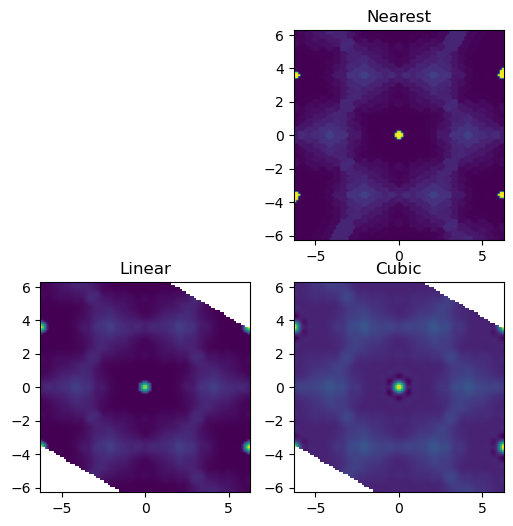

In [55]:
#plt.subplot(221)
#plt.imshow(func(grid_x, grid_y).T, extent=(0, 1, 0, 1), origin='lower')
#plt.plot(points[:, 0], points[:, 1], 'k.', ms=1)   # data
#plt.title('Original')
extent_plot = (-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi)
plt.subplot(222)
plt.imshow(grid_z0.T, extent=extent_plot, origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=extent_plot, origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=extent_plot, origin='lower')
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()

# Unit cell structure factor

In [114]:
unit_cells = np.load("./data/unitcells.npy", allow_pickle=True).flat[0]
#select the best (minimum energy) array to plot
all_energies = []
for i in range(num_reads):
    all_energies.append(response.record[i][1])

best_array = response.record[np.argmin(all_energies)][0]
qubit_variables = np.array(response.variables)
#make as dict
best_array_dict = {}
for j in range(len(best_array)):
    best_array_dict.update({qubit_variables[j]:best_array[j]})

locs = []
arrows = []
colors = []
fac = 0.5
all_colors = ["red", "blue", "green", "black"]

vec1 = 2*np.array([1.0, 0.0])
vec2 = 2*np.array([0.5, 0.8660254])

for r1 in unit_cells.keys():
    three_sites = unit_cells[r1]
    r1vec = np.array(r1)
    locs.append(r1vec[0]*vec1 + r1vec[1]*vec2 + 0.5*(np.array([1.0, 0.0]) + np.array([0, 0.8660254])))
    all_data = [best_array_dict[three_sites[i]] for i in range(3)]
    if all_data == [1,-1,-1]:
        arrow_triangle = np.array([1,0])
        col_here = all_colors[0]
    elif all_data == [-1,1,-1]:
        arrow_triangle = np.array([-1/2,np.sqrt(3)/2])
        col_here = all_colors[1]
    elif all_data == [-1,-1,1]:
        arrow_triangle = np.array([-1/2,-np.sqrt(3)/2])
        col_here = all_colors[2]
    else :
        arrow_triangle = np.array([0,0])
        col_here = all_colors[3]
    arrows.append(fac*arrow_triangle)
    colors.append(col_here)

Visualize the unit cell order parameter for a given configuration

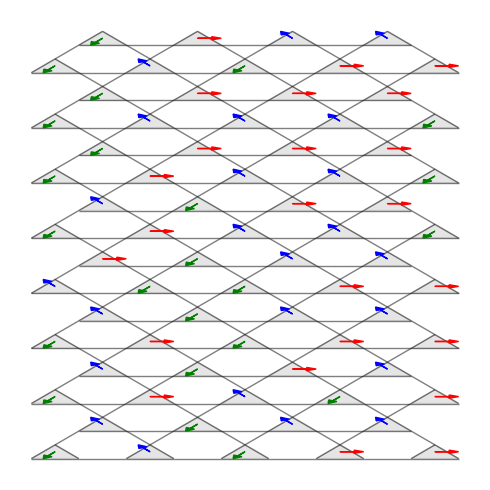

In [123]:
#draw the graph with the specific nodes in red or blue

plt.ion()
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["figure.dpi"]=100

#nx.draw(simplify_Kag_graph, final_qubit_dictionary)
# nodes
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
options = {"edgecolors": "none", "node_size": 60, "alpha": 1.0}
# edges
nx.draw_networkx_edges(simplify_Kag_graph, final_qubit_dictionary, width=1.0, alpha=0.5, ax=ax)
# add the arrows
distance1 = -0.5*(np.array([1.0, 0.0]) + np.array([0, 0.8660254]))
distance2 = 0.5*( np.array([0, 0.8660254]))
distance3 = 0.5*(np.array([1.0, 0.0]) + np.array([0, -0.8660254]))

for i in range(len(locs)):
    sites_of_triangle = [locs[i] + distance1,locs[i] + distance2, locs[i] + distance3 ]
    t1 = plt.Polygon(sites_of_triangle, color="black", alpha = 0.1)
    plt.gca().add_patch(t1)
    plt.arrow(*locs[i], *arrows[i], head_width=0.2, head_length=0.2, fc=colors[i], ec=colors[i], length_includes_head = True)

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')
plt.tight_layout()
plt.axis("off")
plt.show()

Perform the Fourier transform of that triangle order for all configurations

In [136]:
def Triangle_q_for_record(all_record_configs, qubit_dictionary, qubit_variables, L_Kpoints):
    #L_Kpoints needs to be odd to see the q=0 component

    total_K, kx_vals, ky_vals = momentum_grid_kagome(L_Kpoints)

    structure_factor = np.zeros(len(total_K))
    S2_spin = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    num_reads = len(all_record_configs)

    vec1 = 2*np.array([1.0, 0.0])
    vec2 = 2*np.array([0.5, 0.8660254])

    for k in range(num_reads):
        response_analyzed = {}
        for j in range(len(response_array)):
            response_analyzed.update({qubit_variables[j]:all_record_configs[k][j]})

        for kp in range(len(total_K)):
            val_K = np.array([0.0, 0.0]) + 1j*np.array([0.0, 0.0])
            val_mK = np.array([0.0, 0.0]) + 1j*np.array([0.0, 0.0])
            for r1 in qubit_dictionary.keys():
                kpoint = total_K[kp]
                three_sites = qubit_dictionary[r1]
                r1vec_temp = np.array(r1)
                r1vec = r1vec_temp[0]*vec1 + r1vec_temp[1]*vec2 + 0.5*(np.array([1.0, 0.0]) + np.array([0, 0.8660254]))
                all_data = [response_analyzed[three_sites[i]] for i in range(3)]
                if all_data == [1,-1,-1]:
                    arrow_triangle = np.array([1,0])
                elif all_data == [-1,1,-1]:
                    arrow_triangle = np.array([-1/2,np.sqrt(3)/2])
                elif all_data == [-1,-1,1]:
                    arrow_triangle = np.array([-1/2,-np.sqrt(3)/2])
                else :
                    arrow_triangle = np.array([0,0])
                #partA = response_analyzed[three_sites[0]]*np.array([1,0])
                #partB = response_analyzed[three_sites[1]]*np.array([-1/2,np.sqrt(3)/2])
                #partC = response_analyzed[three_sites[2]]*np.array([-1/2, -np.sqrt(3)/2])
                #arrow_triangle = partA + partB + partC
                val_K += np.exp(1j*np.dot(kpoint, r1vec))*(arrow_triangle)
                val_mK += np.exp(-1j*np.dot(kpoint, r1vec))*(arrow_triangle)
            val_K = val_K/len(qubit_dictionary)
            val_mK = val_mK/len(qubit_dictionary)
            structure_factor[kp] += np.linalg.norm(val_K)
            S2_spin[kp] += np.dot(val_K,val_mK)
        if k % 10 == 0:
            print("Done with reads: ", k)

    structure_factor = structure_factor / num_reads
    S2_spin = S2_spin / num_reads

    return total_K, kx_vals, ky_vals, S2_spin, structure_factor
    

In [137]:
all_record_configs = np.array([response.record[k][0] for k in range(num_reads)])
total_K, kx_vals, ky_vals, S2_spin, structure_factor = Triangle_q_for_record(all_record_configs, unit_cells, qubit_variables, 21)

Done with reads:  0
Done with reads:  10
Done with reads:  20
Done with reads:  30
Done with reads:  40
Done with reads:  50
Done with reads:  60
Done with reads:  70
Done with reads:  80
Done with reads:  90
Done with reads:  100
Done with reads:  110
Done with reads:  120
Done with reads:  130
Done with reads:  140
Done with reads:  150
Done with reads:  160
Done with reads:  170
Done with reads:  180
Done with reads:  190


Plotting the bare Q-space data - what is the Brillouin Zone for this new lattice??

Text(0.5, 1.0, '$\\langle|\\vec{\\Phi}(q)|\\rangle$')

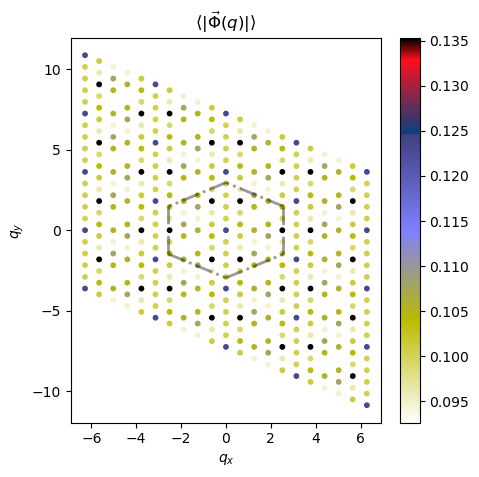

In [145]:
#norm = plt.Normalize(0,(1/3)**2)
cmap = plt.cm.get_cmap('gist_stern_r')
#finalSQ = np.absolute(S2_spin) - np.absolute(structure_factor)*np.absolute(structure_factor_mK)
#finalSQ = np.absolute(S2_spin)
finalSQ = structure_factor
#finalSQ = final_spin_Q2 - final_spin_Q**2
plt.scatter(kx_vals, ky_vals, s=10, c=finalSQ, cmap=cmap)
plt.colorbar()
theta_list = [(2*np.pi*i/6 + np.pi/6) for i in range(7)]
lside = 4*np.pi/3/np.sqrt(2)
for j in range(6):
    plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])],
     [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)
plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
plt.title(r'$\langle|\vec{\Phi}(q)|\rangle$')

Clearly this has some order, so it isnt a Gamma = 0 state afterall! Impact of finite transverse field is seen

Interpolation

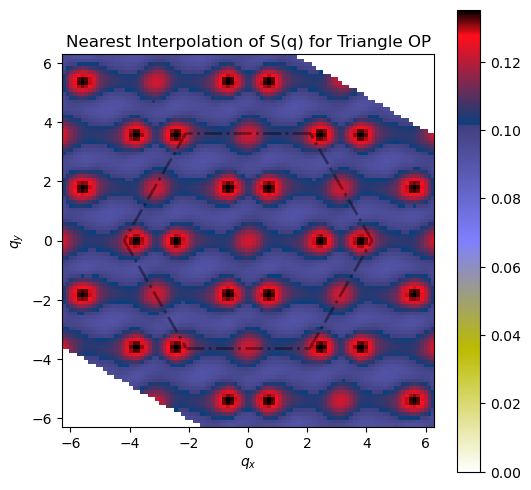

In [151]:
from scipy.interpolate import griddata
xlim = np.linspace(-2*np.pi, 2*np.pi, 100)
ylim = np.linspace(-2*np.pi, 2*np.pi, 100)
#xlim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
#ylim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
grid_x, grid_y = np.meshgrid(xlim, ylim, indexing='ij')
points = total_K
values = structure_factor
grid_z0 = griddata(points, values, (grid_x, grid_y), method='cubic')
#possible methods: nearest, square, cubic


#plt.subplot(221)
#plt.imshow(func(grid_x, grid_y).T, extent=(0, 1, 0, 1), origin='lower')
#plt.plot(points[:, 0], points[:, 1], 'k.', ms=1)   # data
#plt.title('Original')
extent_plot = (-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi)
norm = plt.Normalize(0,np.max(values))

cmap = plt.cm.get_cmap('gist_stern_r')
plt.imshow(grid_z0.T, extent=extent_plot, origin='lower', cmap = cmap, norm = norm)
plt.title('Nearest Interpolation of S(q) for Triangle OP')
plt.colorbar()
plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
theta_list = [2*np.pi*i/6 for i in range(7)]
lside = 4*np.pi/3
for j in range(6):
    plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])],
     [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)
plt.gcf().set_size_inches(6, 6)
plt.show()